In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
try:
    plt.style.use("/Users/asludds/Dropbox/mplstyle.mplstyle")
except:
    plt.style.use("../../mplstyle.mplstyle")

from tqdm import tqdm

In [143]:
class SiN_Si_add_drop_ring_resonator():
    def __init__(self,kappa_squared,radius,round_trip_loss_dB=0.2):
        self.kappa = np.sqrt(kappa_squared)
        self.r = np.sqrt(1-kappa_squared)
        self.radius = radius
        self.round_trip_loss_dB = round_trip_loss_dB
        self.Lrt_SiN = 2 * np.pi * self.radius #The length of silicon nitride in a round trip
        self.ng = (1.93 + 3.6)/2 #assume linear change along bend from 1.93 to 2.6
        
        self.Lambda_res = 1310e-9
        self.a = np.exp(-self.round_trip_loss_dB/(2*4.34)) #Put in an initial guess of "a" that is just the loss from SiN

    def transmission(self,phi=0):
        # Calculates transmission through ring. Assumes on resonance by default
        num = (1-self.r**2)*(1-self.r**2)*self.a
        denom = 1 - 2 * self.r**2 * self.a * np.cos(phi) + (self.r**2 * self.a)**2
        return num/denom 
    
    def Q(self):
        # The loaded quality factor for an add-drop ring resonator
        num = np.pi * (self.ng * self.Lrt_SiN) * np.sqrt(self.r**2 *self.a)
        denom = self.Lambda_res * (1 - self.r**2 * self.a)
        return num/denom
    
    def FSR(self):
        return self.Lambda_res**2/(self.ng * self.Lrt_SiN)
    
    def FWHM(self):
        return self.Lambda_res/self.Q()
    
    def Finesse(self):
        return self.FSR()/self.FWHM()
    
    def power_enhancement(self):
        return self.Finesse()/np.pi
    
    def wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        lambda_sweep = np.linspace(lambda_start,lambda_stop,num=num)
        phase_sweep = 2*np.pi * (lambda_sweep - self.Lambda_res)/self.FSR()
        transmission_storage = [self.transmission(phi=i) for i in phase_sweep]
        return lambda_sweep, np.array(transmission_storage)
    
class Vernier_rings_in_longitudinal_cavity():
    def __init__(self,L_long,kappa_squared,radius1,radius2,round_trip_loss_dB=0.2):
        self.ring1 = SiN_Si_add_drop_ring_resonator(kappa_squared,radius1,round_trip_loss_dB)
        self.ring2 = SiN_Si_add_drop_ring_resonator(kappa_squared,radius2,round_trip_loss_dB)
        self.L_long = L_long

    def transmission_through_mirror(self):
        return self.ring1.transmission() * self.ring2.transmission()
    
    def transmission_through_sagnac(self):
        return self.ring1.transmission()**2 * self.ring2.transmission()**2
    
    def Mirror_Lrt_eff(self):
        return 2*self.L_long + (0.5 + (1 - self.ring1.kappa**2)/(self.ring1.kappa**2))* (self.ring1.Lrt_SiN) + (0.5 + (1 - self.ring2.kappa**2)/(self.ring2.kappa**2))* (self.ring2.Lrt_SiN)
    
    def Sagnac_Lrt_eff(self):
        return 2*self.L_long + 2*(0.5 + (1 - self.ring1.kappa**2)/(self.ring1.kappa**2))* (self.ring1.Lrt_SiN) + 2*(0.5 + (1 - self.ring2.kappa**2)/(self.ring2.kappa**2))* (self.ring2.Lrt_SiN)
    
    def Mirror_FSR_longitudinal(self):
        return self.ring1.Lambda_res**2/(self.ring1.ng * self.Mirror_Lrt_eff())
    
    def Sagnac_FSR_longitudinal(self):
        return self.ring1.Lambda_res**2/(self.ring1.ng * self.Sagnac_Lrt_eff())
    
    def Vernier_FSR(self):
        return self.ring1.FSR()*self.ring2.FSR()/abs(self.ring1.FSR() - self.ring2.FSR())
    
    def Mirror_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=50000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        return wavelengths, ring1_sweep * ring2_sweep
    
    def Sagnac_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=50000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        return wavelengths, ring1_sweep**2 * ring2_sweep**2
    
    def Mirror_Vernier_SMSR(self):
        wav,amp = self.Mirror_wavelength_sweep(self.ring1.Lambda_res - max(self.ring1.FSR(),self.ring2.FSR()) - 50e-12,self.ring1.Lambda_res - min(self.ring1.FSR(),self.ring2.FSR()) + 50e-12,num=50000)
        amp_at_Vernier_sidemode = np.max(amp)
        amp_at_1310nm = self.transmission_through_mirror()
        return amp_at_1310nm/amp_at_Vernier_sidemode
    
    def Sagnac_Vernier_SMSR(self):
        wav,amp = self.Sagnac_wavelength_sweep(self.ring1.Lambda_res - max(self.ring1.FSR(),self.ring2.FSR()) - 50e-12,self.ring1.Lambda_res - min(self.ring1.FSR(),self.ring2.FSR()) + 50e-12,num=50000)
        amp_at_Vernier_sidemode = np.max(amp)
        amp_at_1310nm = self.transmission_through_sagnac()
        return amp_at_1310nm/amp_at_Vernier_sidemode
    
    def Mirror_longitudinal_SMSR(self):
        wav,amp = self.Mirror_wavelength_sweep()
        Lambda = self.ring1.Lambda_res - self.Mirror_FSR_longitudinal()
        amp_at_1310nm = amp[np.argmin(np.abs(wav-self.ring1.Lambda_res))]
        amp_at_long_FSR = amp[np.argmin(np.abs(wav-Lambda))]
        return amp_at_1310nm/amp_at_long_FSR
    
    def Sagnac_longitudinal_SMSR(self):
        wav,amp = self.Sagnac_wavelength_sweep()
        Lambda = self.ring1.Lambda_res - self.Sagnac_FSR_longitudinal()
        amp_at_1310nm = amp[np.argmin(np.abs(wav-self.ring1.Lambda_res))]
        amp_at_long_FSR = amp[np.argmin(np.abs(wav-Lambda))]
        return amp_at_1310nm/amp_at_long_FSR
    
    def Mirror_longitudinal_cavity_transmission(self, Lambda):
        R1 = 0.9 #Values are placeholders. The Q of this fabry-perot cavity doesn't matter for calculating SMSR
        R2 = 0.9
        T1 = 1 - R1
        T2 = 1 - R2
        length_of_longitudinal_cavity = self.Mirror_Lrt_eff()/2 #Factor of two because the function calculates the round trip length
        phi_offset = 2*np.pi*self.ring1.ng*length_of_longitudinal_cavity/self.ring1.Lambda_res #Subtract a phase offset to have fabry-perot cavity on resonance at 1310nm
        phi = 2 * np.pi * self.ring1.ng * length_of_longitudinal_cavity/ Lambda - phi_offset
        num = -1 * np.sqrt(T1*T2) *  np.exp(-1j * phi)
        denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * phi)
        H = num/denom
        return np.real(H * np.conj(H))
    
    def Sagnac_longitudinal_cavity_transmission(self, Lambda):
        R1 = 0.9 #Values are placeholders. The Q of this fabry-perot cavity doesn't matter for calculating SMSR
        R2 = 0.9
        T1 = 1 - R1
        T2 = 1 - R2
        length_of_longitudinal_cavity = self.Sagnac_Lrt_eff()/2 #Factor of two because the function calculates the round trip length
        phi_offset = 2*np.pi*self.ring1.ng*length_of_longitudinal_cavity/self.ring1.Lambda_res #Subtract a phase offset to have fabry-perot cavity on resonance at 1310nm
        phi = 2 * np.pi * self.ring1.ng * length_of_longitudinal_cavity/ Lambda - phi_offset
        num = -1 * np.sqrt(T1*T2) *  np.exp(-1j * phi)
        denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * phi)
        H = num/denom
        return np.real(H * np.conj(H))

    def Mirror_longitudinal_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=50000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        long_cavity_sweep = np.array([self.Mirror_longitudinal_cavity_transmission(i) for i in wavelengths])
        return wavelengths, ring1_sweep * ring2_sweep * long_cavity_sweep
    
    def Sagnac_longitudinal_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=50000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        long_cavity_sweep = np.array([self.Sagnac_longitudinal_cavity_transmission(i) for i in wavelengths])
        return wavelengths, ring1_sweep**2 * ring2_sweep**2 * long_cavity_sweep
    
    def is_device_a_good_candidate(self,mirror=True,printy=True):
        if mirror == True:
            device_is_good_candidate = True
            if 10*np.log10(self.Mirror_longitudinal_SMSR()) < 3: # Need at least 3dB sidemode suppression to achieve good laser SMSR
                device_is_good_candidate = False
                if printy == True: print("Vernier mirror device does not have sufficient longitudinal SMSR")
            elif 10*np.log10(self.transmission_through_mirror()) < -1.8: #Losses > 1.8 dB from the mirror make reaching 25mW very difficult
                device_is_good_candidate = False
                if printy == True: print("Vernier mirror device has too much loss")
            elif self.Vernier_FSR() < 40e-9: #Vernier FSR should extend beyond the gain bandwidth
                device_is_good_candidate = False
                if printy == True: print("Vernier mirror device does not have sufficient Vernier FSR")
            elif 10*np.log10(self.Mirror_Vernier_SMSR()) < 3: #Need at least 3dB sidemode suppression to achieve good laser SMSR
                device_is_good_candidate = False
                if printy == True: print("Vernier mirror device does not have sufficient Vernier SMSR")
            if device_is_good_candidate == False:
                if printy == True: print("Vernier mirror device is not a good candidate")
            else:
                if printy == True: print("Vernier mirror device is a good candidate")
            return device_is_good_candidate
        else: #Sagnac
            device_is_good_candidate = True
            if 10*np.log10(self.Sagnac_longitudinal_SMSR()) < 3: # Need at least 3dB sidemode suppression to achieve good laser SMSR
                device_is_good_candidate = False
                if printy == True: print("Vernier sagnac device does not have sufficient longitudinal SMSR")
            elif 10*np.log10(self.transmission_through_sagnac()) < -1.8: #Losses > 1.8 dB from the sagnac make reaching 25mW very difficult
                device_is_good_candidate = False
                if printy == True: print("Vernier sagnac device has too much loss")
            elif self.Vernier_FSR() < 40e-9: #Vernier FSR should extend beyond the gain bandwidth
                device_is_good_candidate = False
                if printy == True: print("Vernier sagnac device does not have sufficient Vernier FSR")
            elif 10*np.log10(self.Sagnac_Vernier_SMSR()) < 3: #Need at least 3dB sidemode suppression to achieve good laser SMSR
                device_is_good_candidate = False
                if printy == True: print("Vernier sagnac device does not have sufficient Vernier SMSR")
            if device_is_good_candidate == False:
                if printy == True: print("Sagnac device is not a good candidate")
            else:
                if printy == True: print("Sagnac device is a good candidate")
            return device_is_good_candidate

Transmission through Vernier Mirror (dB): -2.5609250437137545
Single ring Q:  5943.676109431785
Longitudinal FSR (pm): 60.9510449392753
Mirror Longitudinal SMSR (dB): 2.524214762162371


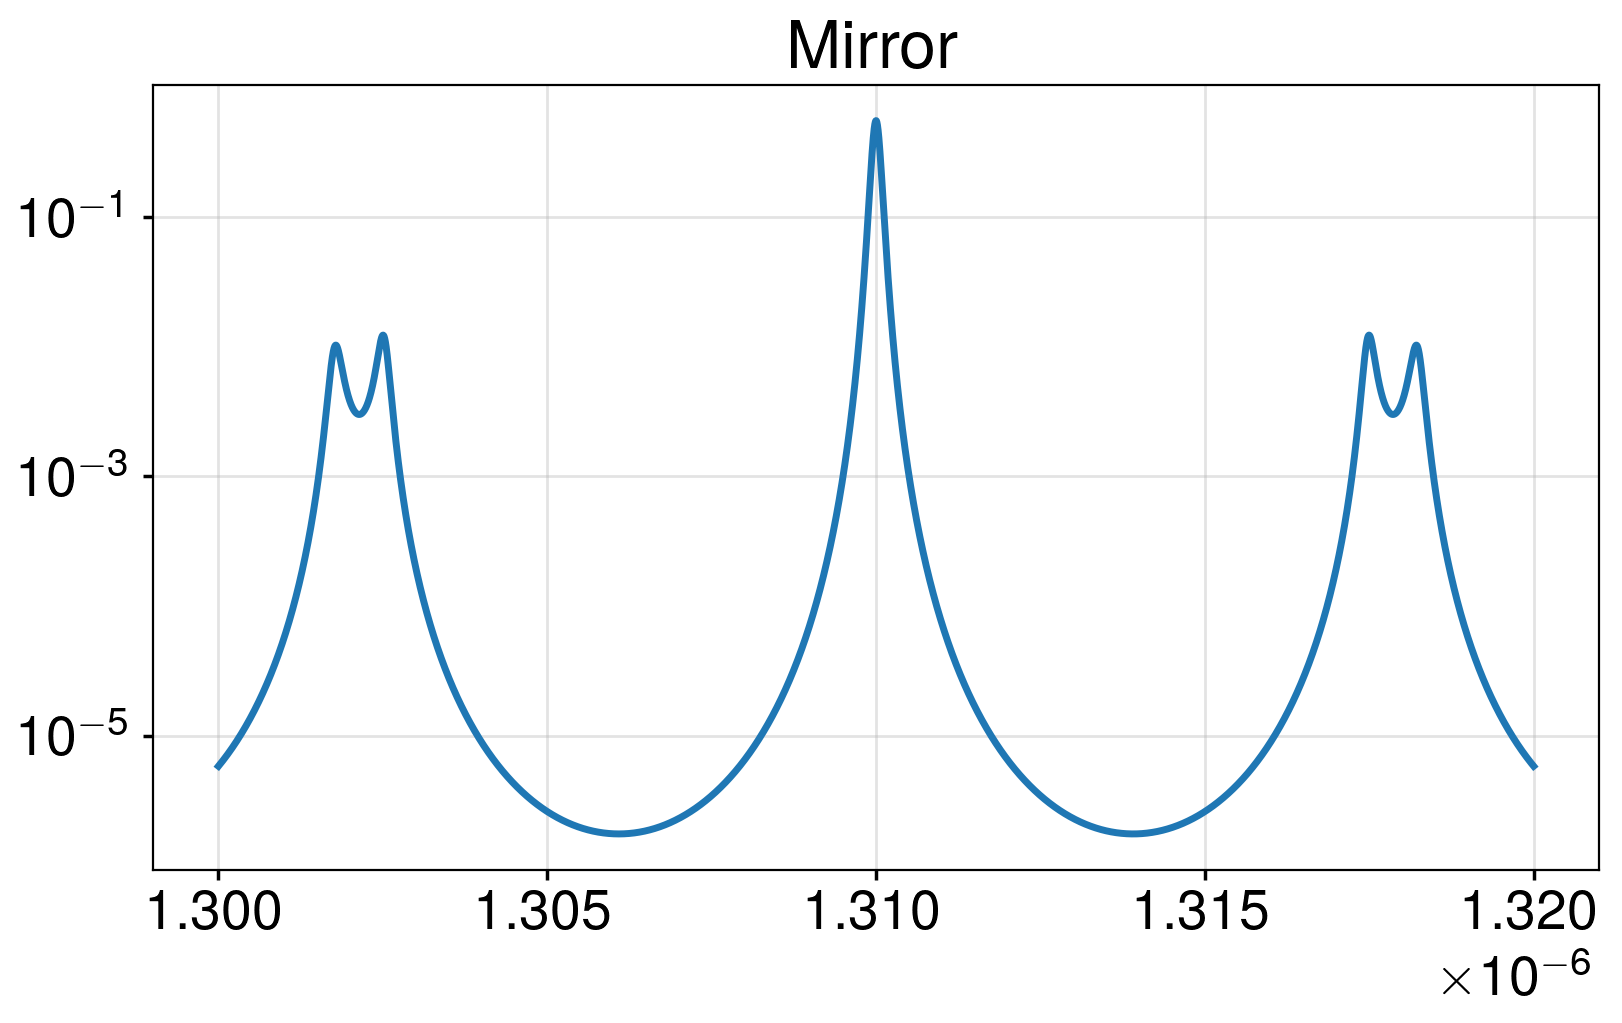

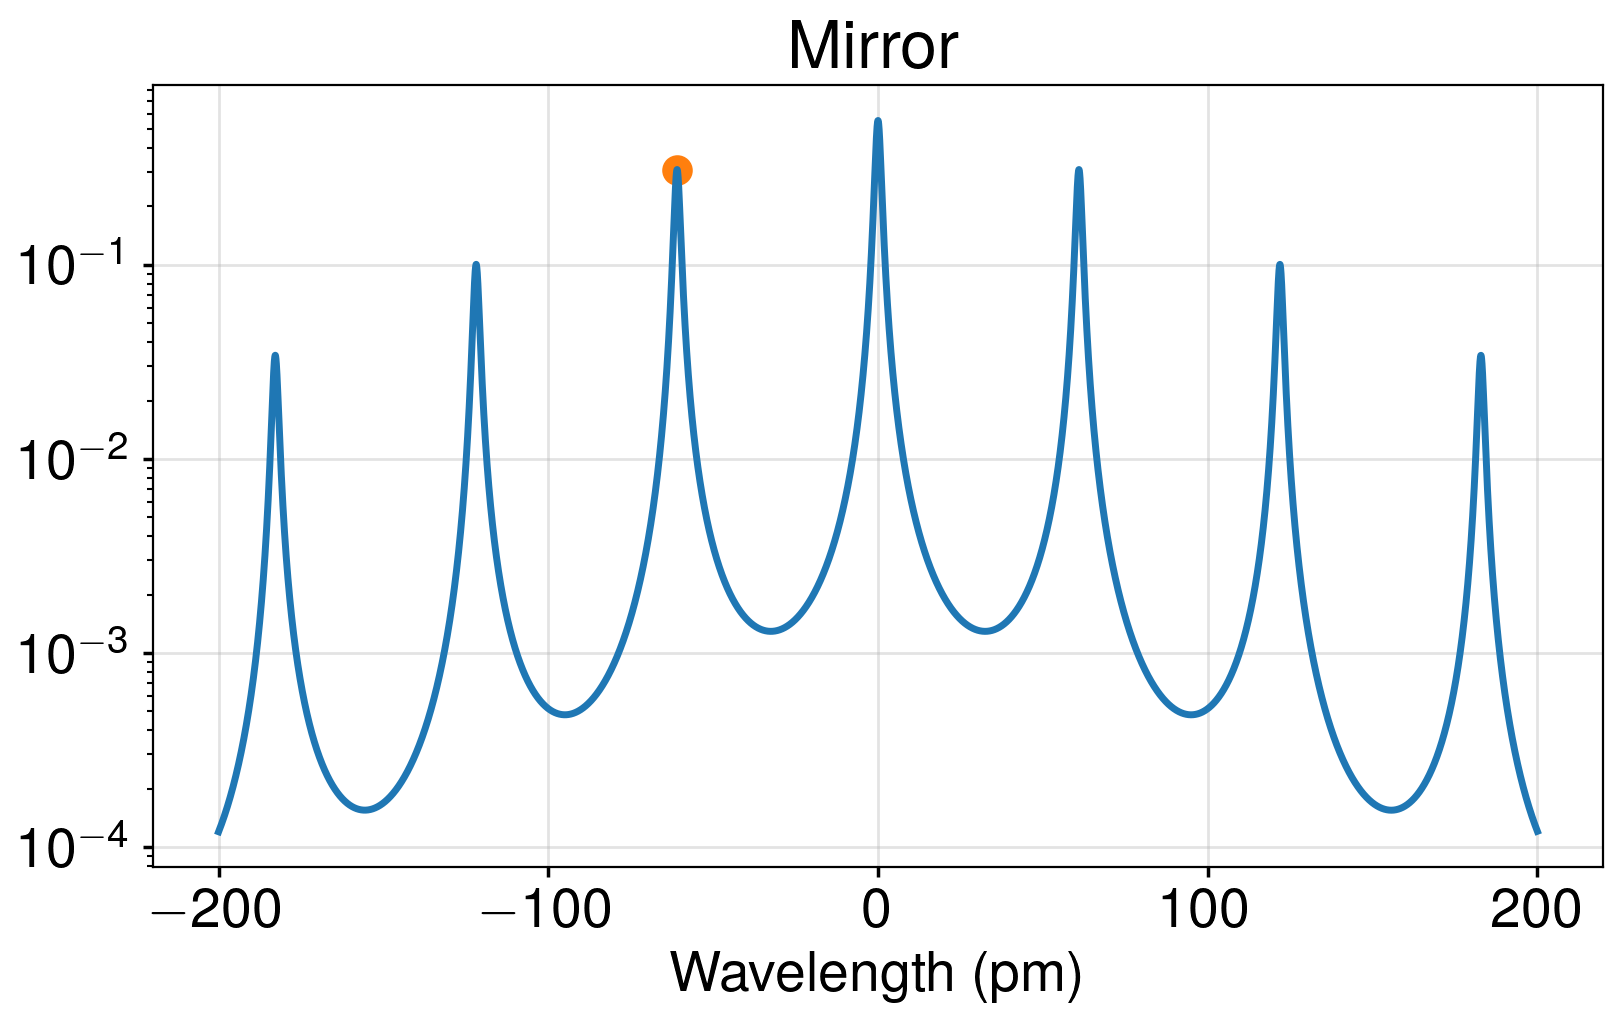

Transmission through Vernier Mirror (dB): -5.121850087427507
Single ring Q:  5943.676109431785
Sagnac Longitudinal SMSR (dB): 3.5832225833091833


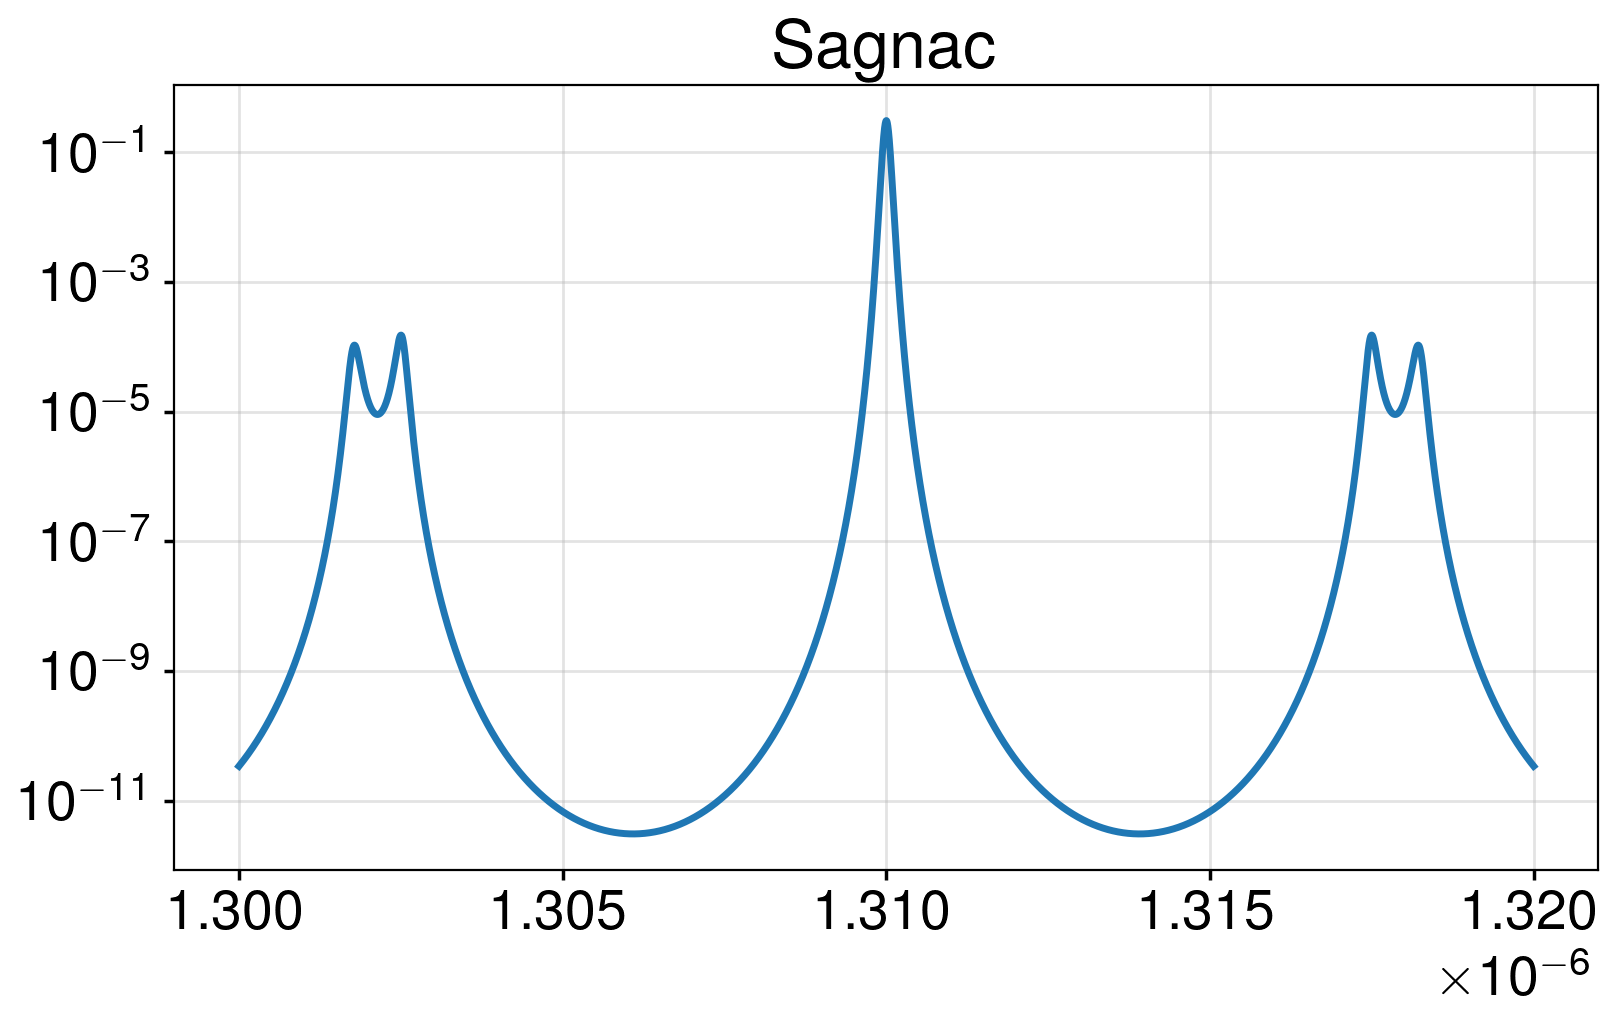

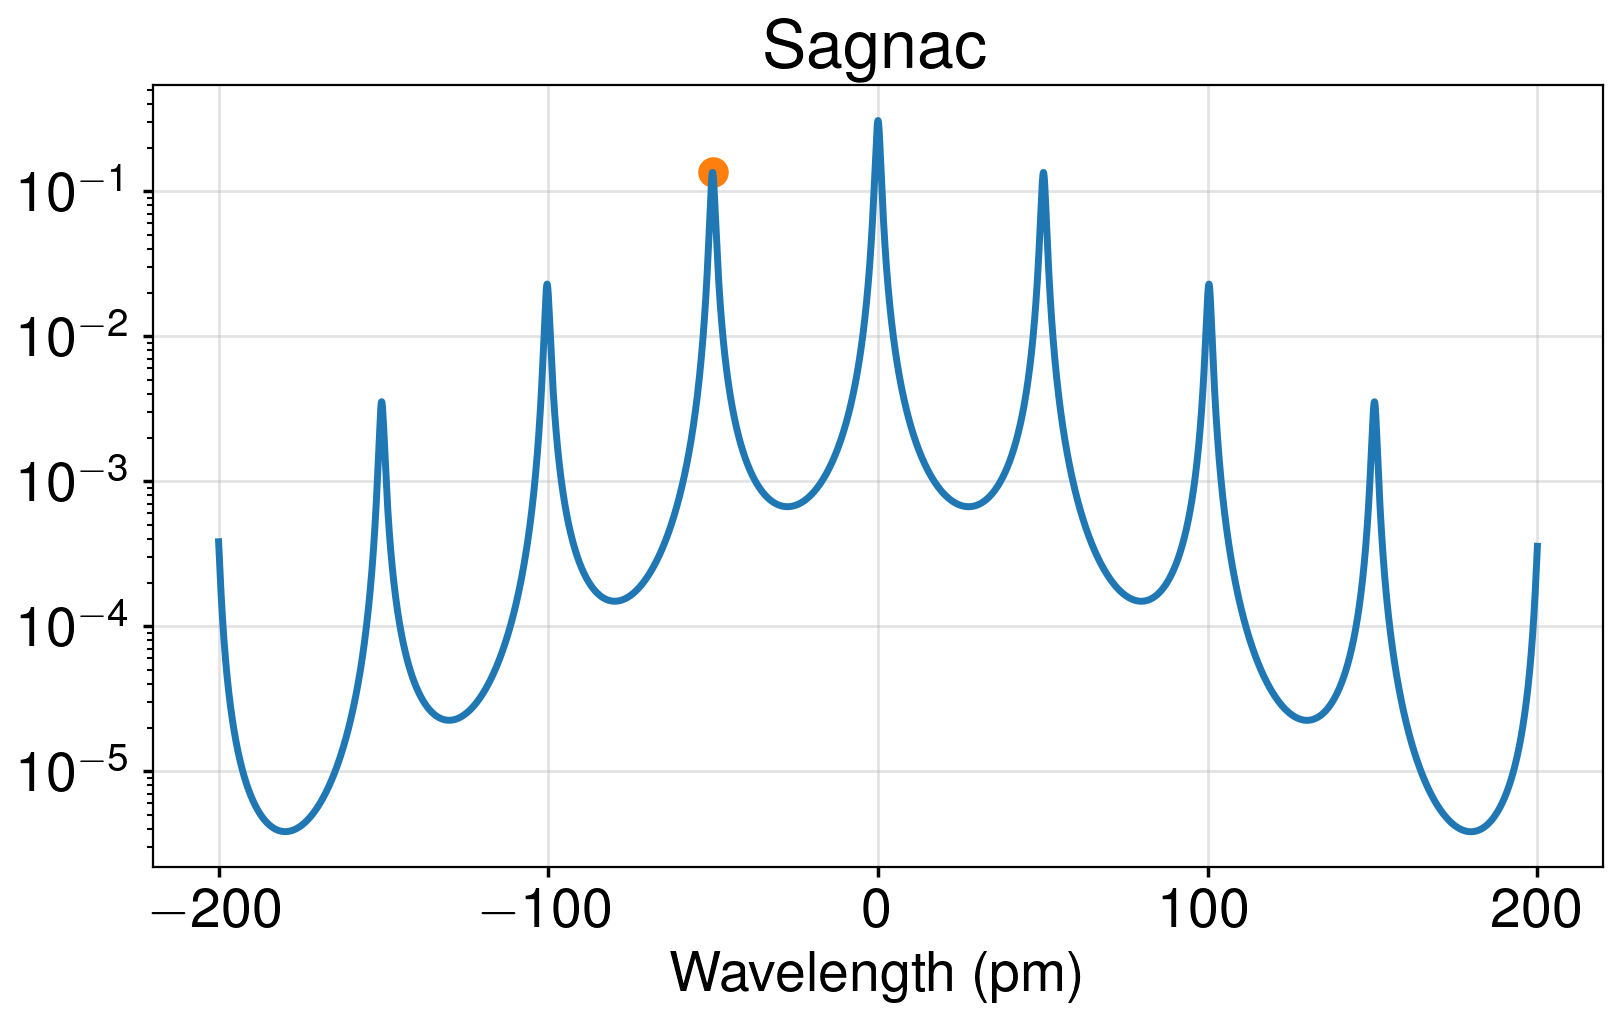

Vernier mirror device does not have sufficient longitudinal SMSR
Vernier mirror device is not a good candidate
Vernier sagnac device has too much loss
Sagnac device is not a good candidate


In [144]:
kappa_squared = 0.07
r1 = 12e-6
r2 = 1.1*r1
tmp = Vernier_rings_in_longitudinal_cavity(4e-3,kappa_squared,r1,r2,round_trip_loss_dB=0.1)

wav,amp = tmp.Mirror_wavelength_sweep(1300e-9,1320e-9,num=10000)
print("Transmission through Vernier Mirror (dB):", 10*np.log10(tmp.transmission_through_mirror()))
print("Single ring Q: ", tmp.ring1.Q())
print("Longitudinal FSR (pm):",tmp.Mirror_FSR_longitudinal()*1e12)
print("Mirror Longitudinal SMSR (dB):", 10*np.log10(tmp.Mirror_longitudinal_SMSR()))

plt.figure()
plt.semilogy(wav,amp)
plt.title("Mirror")
plt.show()

wav, amp = tmp.Mirror_longitudinal_wavelength_sweep(1309.8e-9,1310.2e-9,num=50000)
plt.figure()
plt.semilogy((wav - tmp.ring1.Lambda_res)*1e12,amp)
plt.scatter(( - tmp.Mirror_FSR_longitudinal())*1e12,amp[np.argmin(np.abs(wav - (tmp.ring1.Lambda_res - tmp.Mirror_FSR_longitudinal())))],c='C1')
plt.title("Mirror")
plt.xlabel("Wavelength (pm)")
plt.show()

wav,amp = tmp.Sagnac_wavelength_sweep(1300e-9,1320e-9,num=10000)
print("Transmission through Vernier Mirror (dB):", 10*np.log10(tmp.transmission_through_sagnac()))
print("Single ring Q: ", tmp.ring1.Q())
print("Sagnac Longitudinal SMSR (dB):", 10*np.log10(tmp.Sagnac_longitudinal_SMSR()))

plt.figure()
plt.semilogy(wav,amp)
plt.title("Sagnac")
plt.show()

wav, amp = tmp.Sagnac_longitudinal_wavelength_sweep(1309.8e-9,1310.2e-9,num=50000)
plt.figure()
plt.semilogy((wav - tmp.ring1.Lambda_res)*1e12,amp)
plt.scatter(( - tmp.Sagnac_FSR_longitudinal())*1e12,amp[np.argmin(np.abs(wav - (tmp.ring1.Lambda_res - tmp.Sagnac_FSR_longitudinal())))],c='C1')
plt.title("Sagnac")
plt.xlabel("Wavelength (pm)")
plt.show()

tmp.is_device_a_good_candidate(mirror=True);
tmp.is_device_a_good_candidate(mirror=False);

kappa^{2} sweep: 19it [04:18, 13.60s/it]


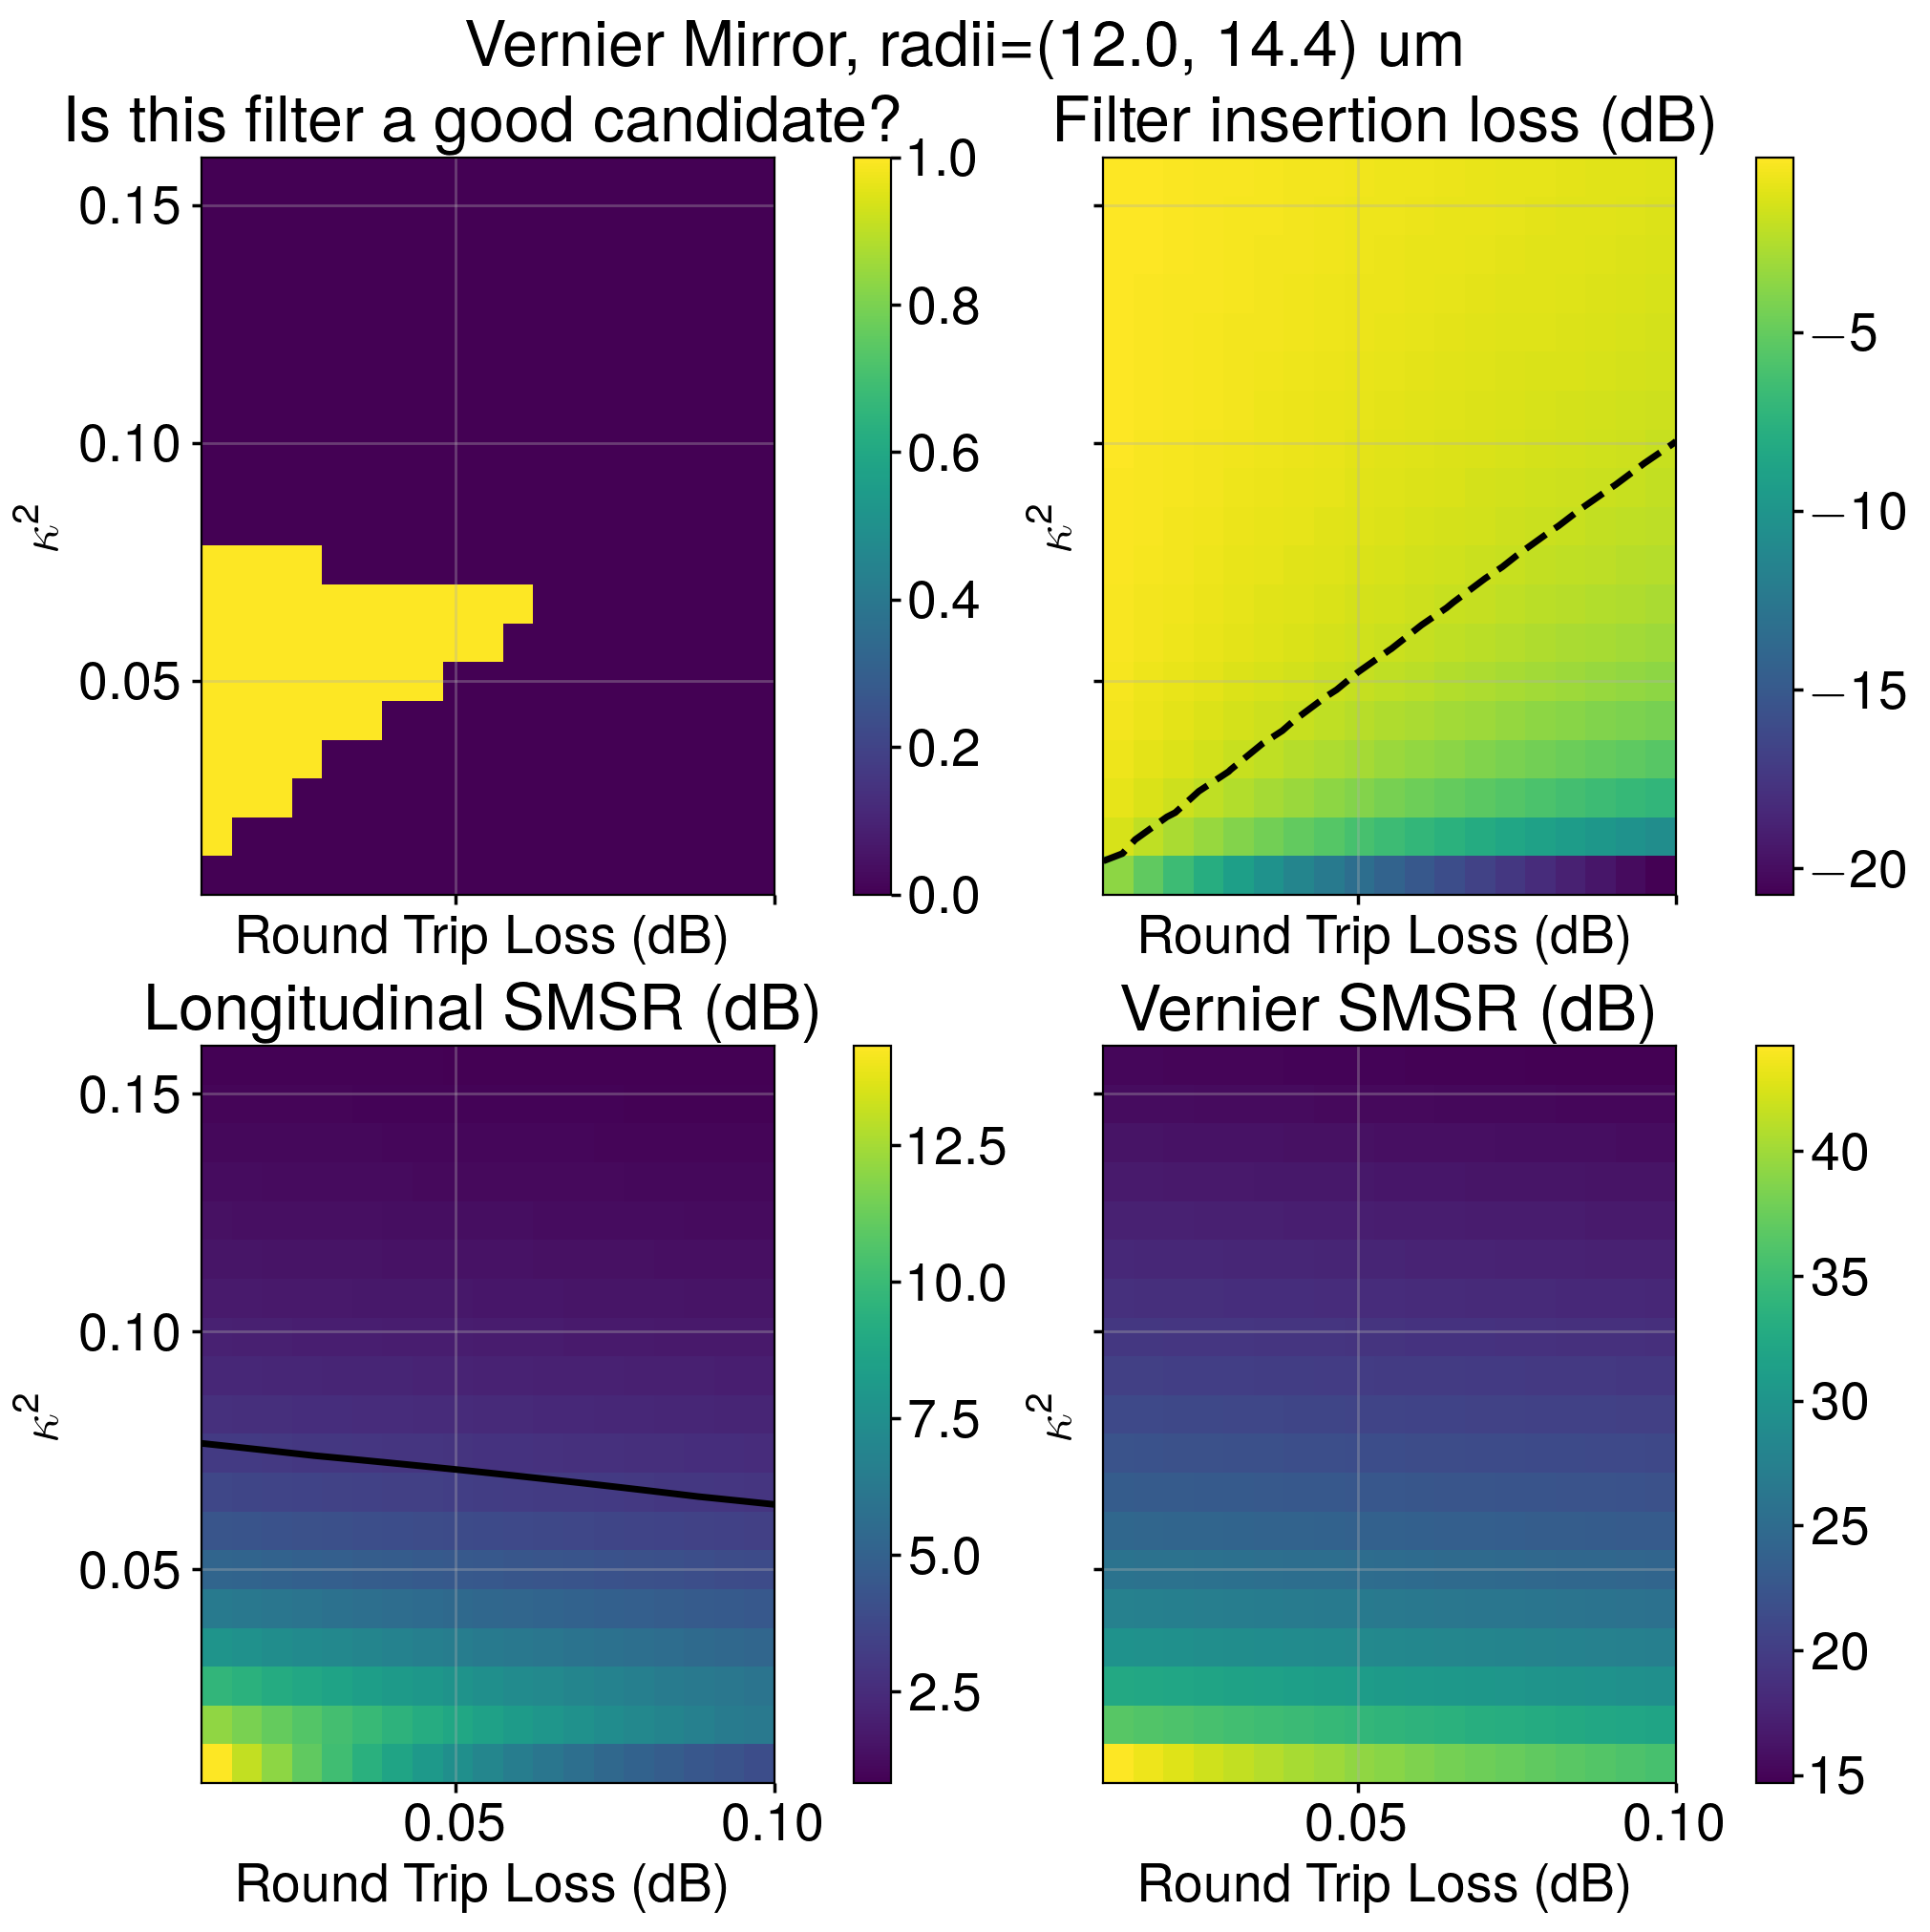

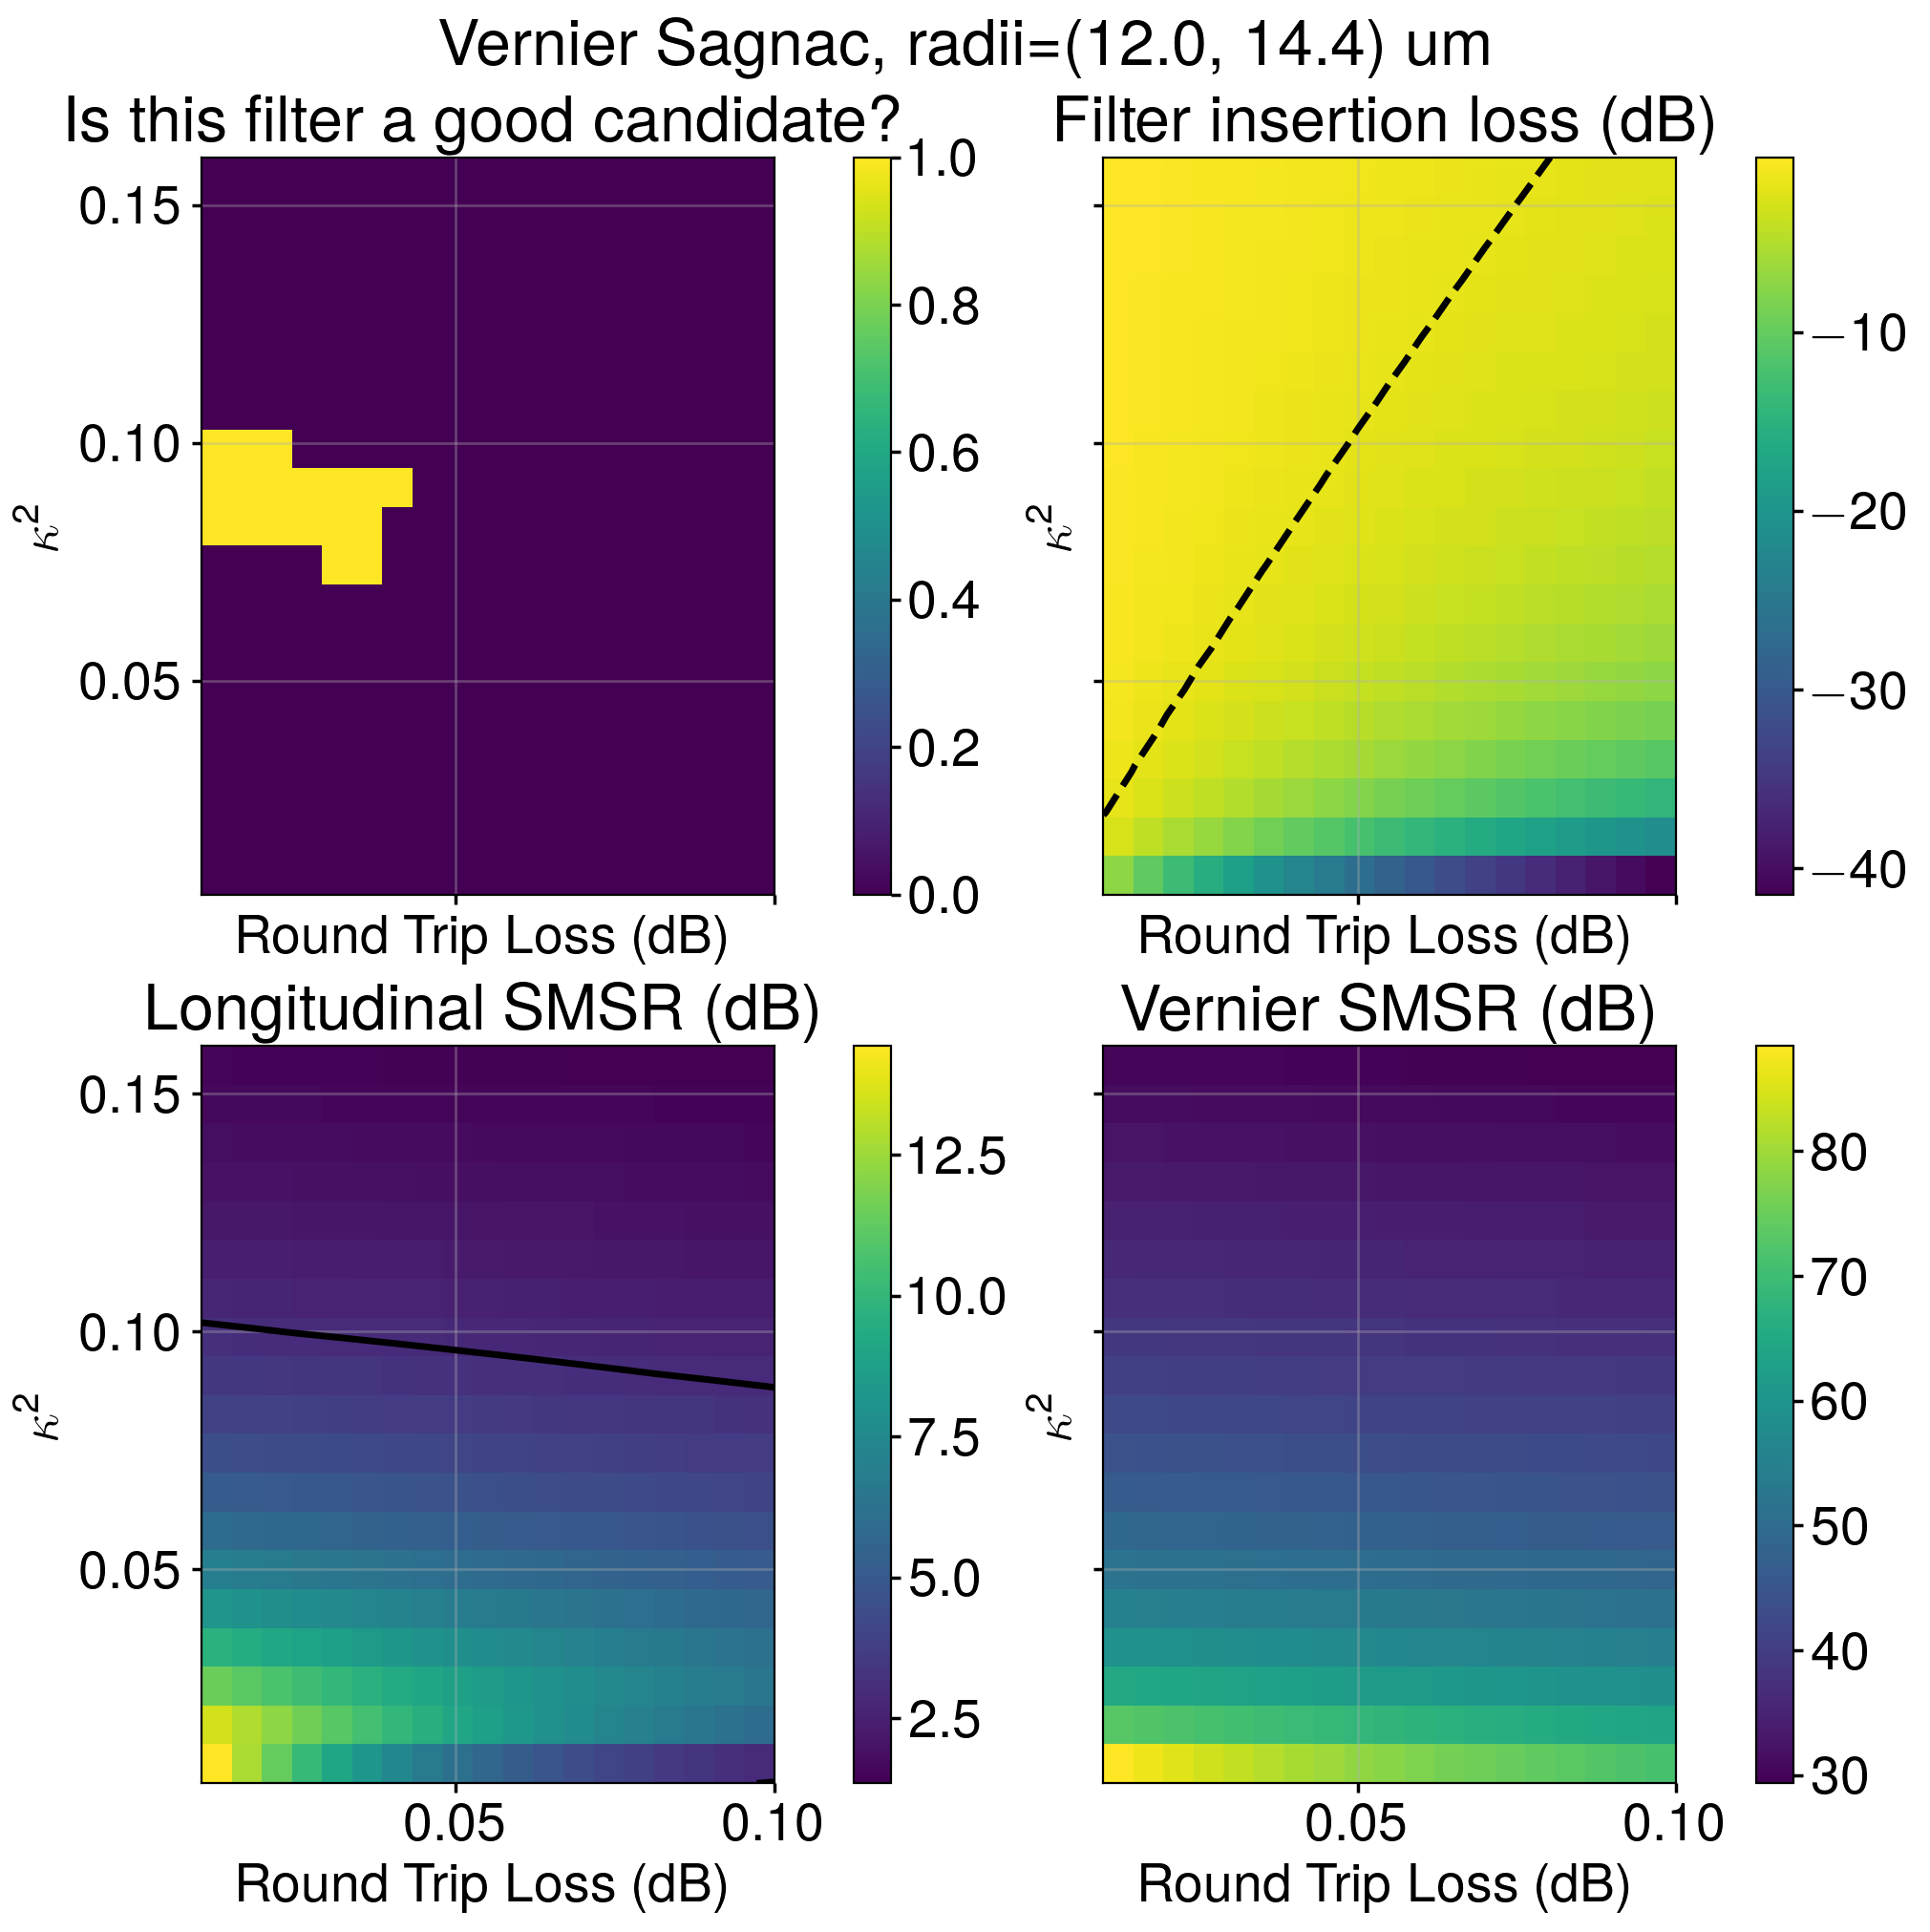

kappa^{2} sweep: 19it [04:15, 13.43s/it]


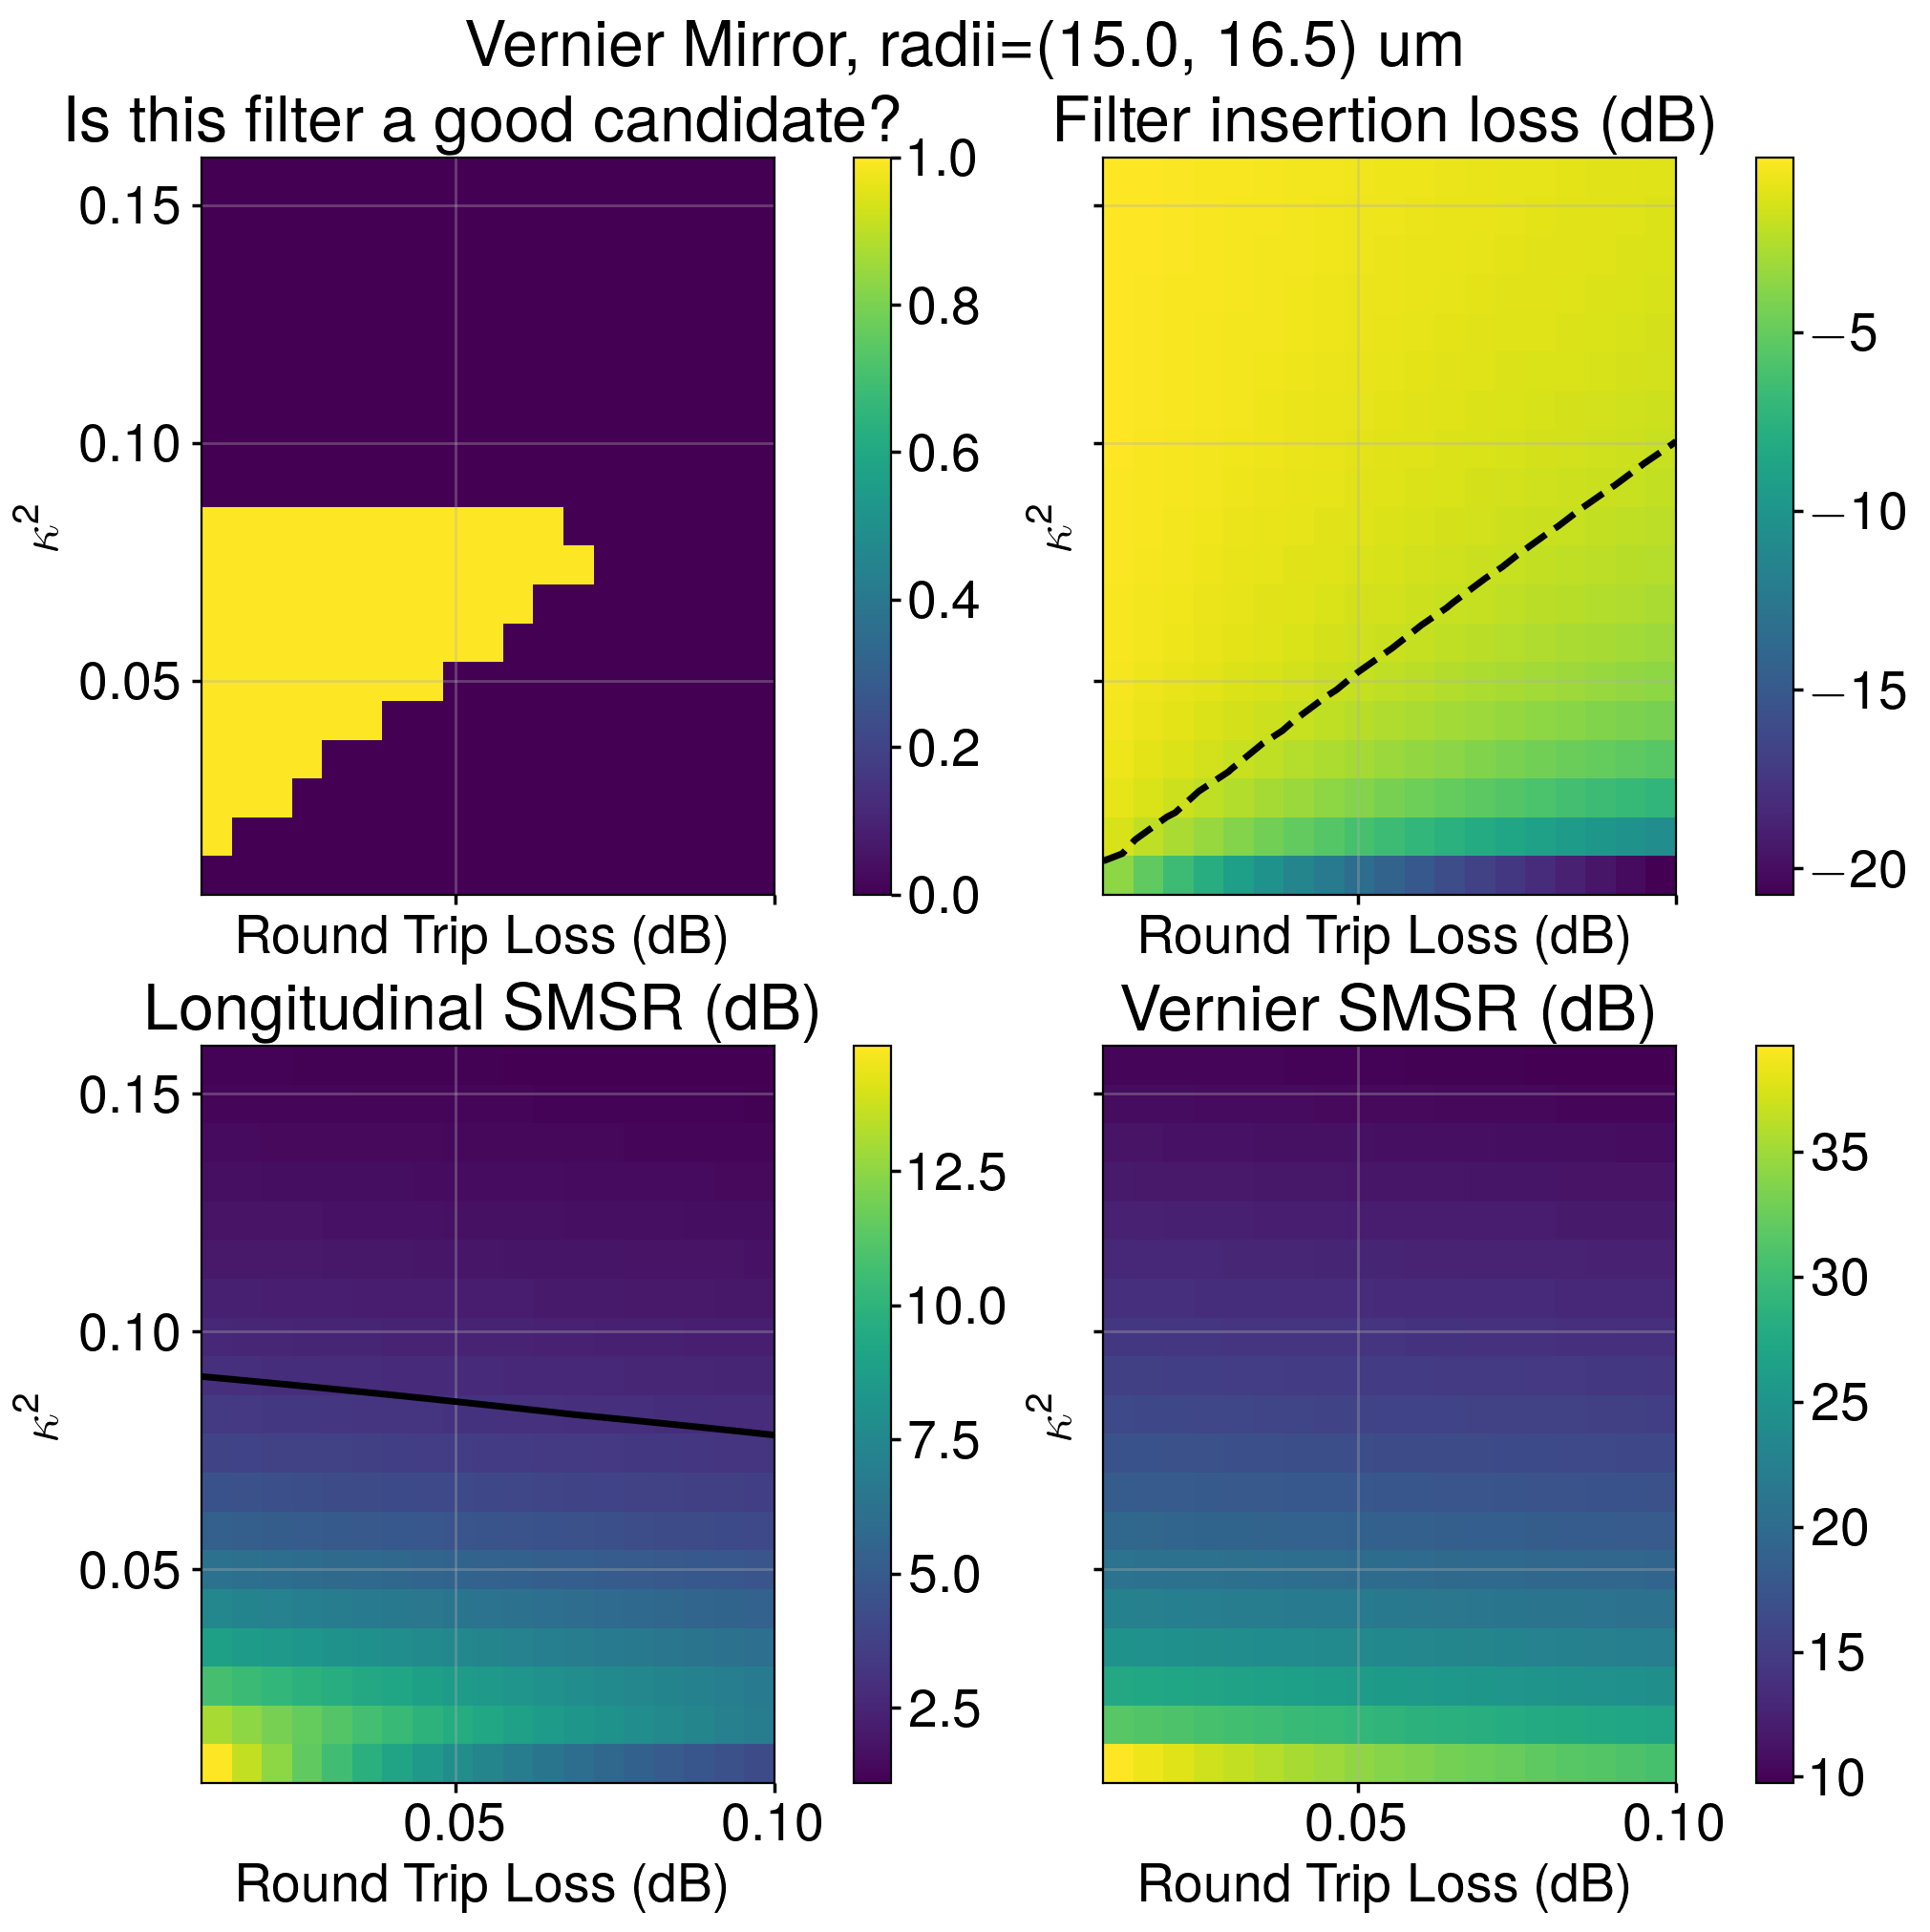

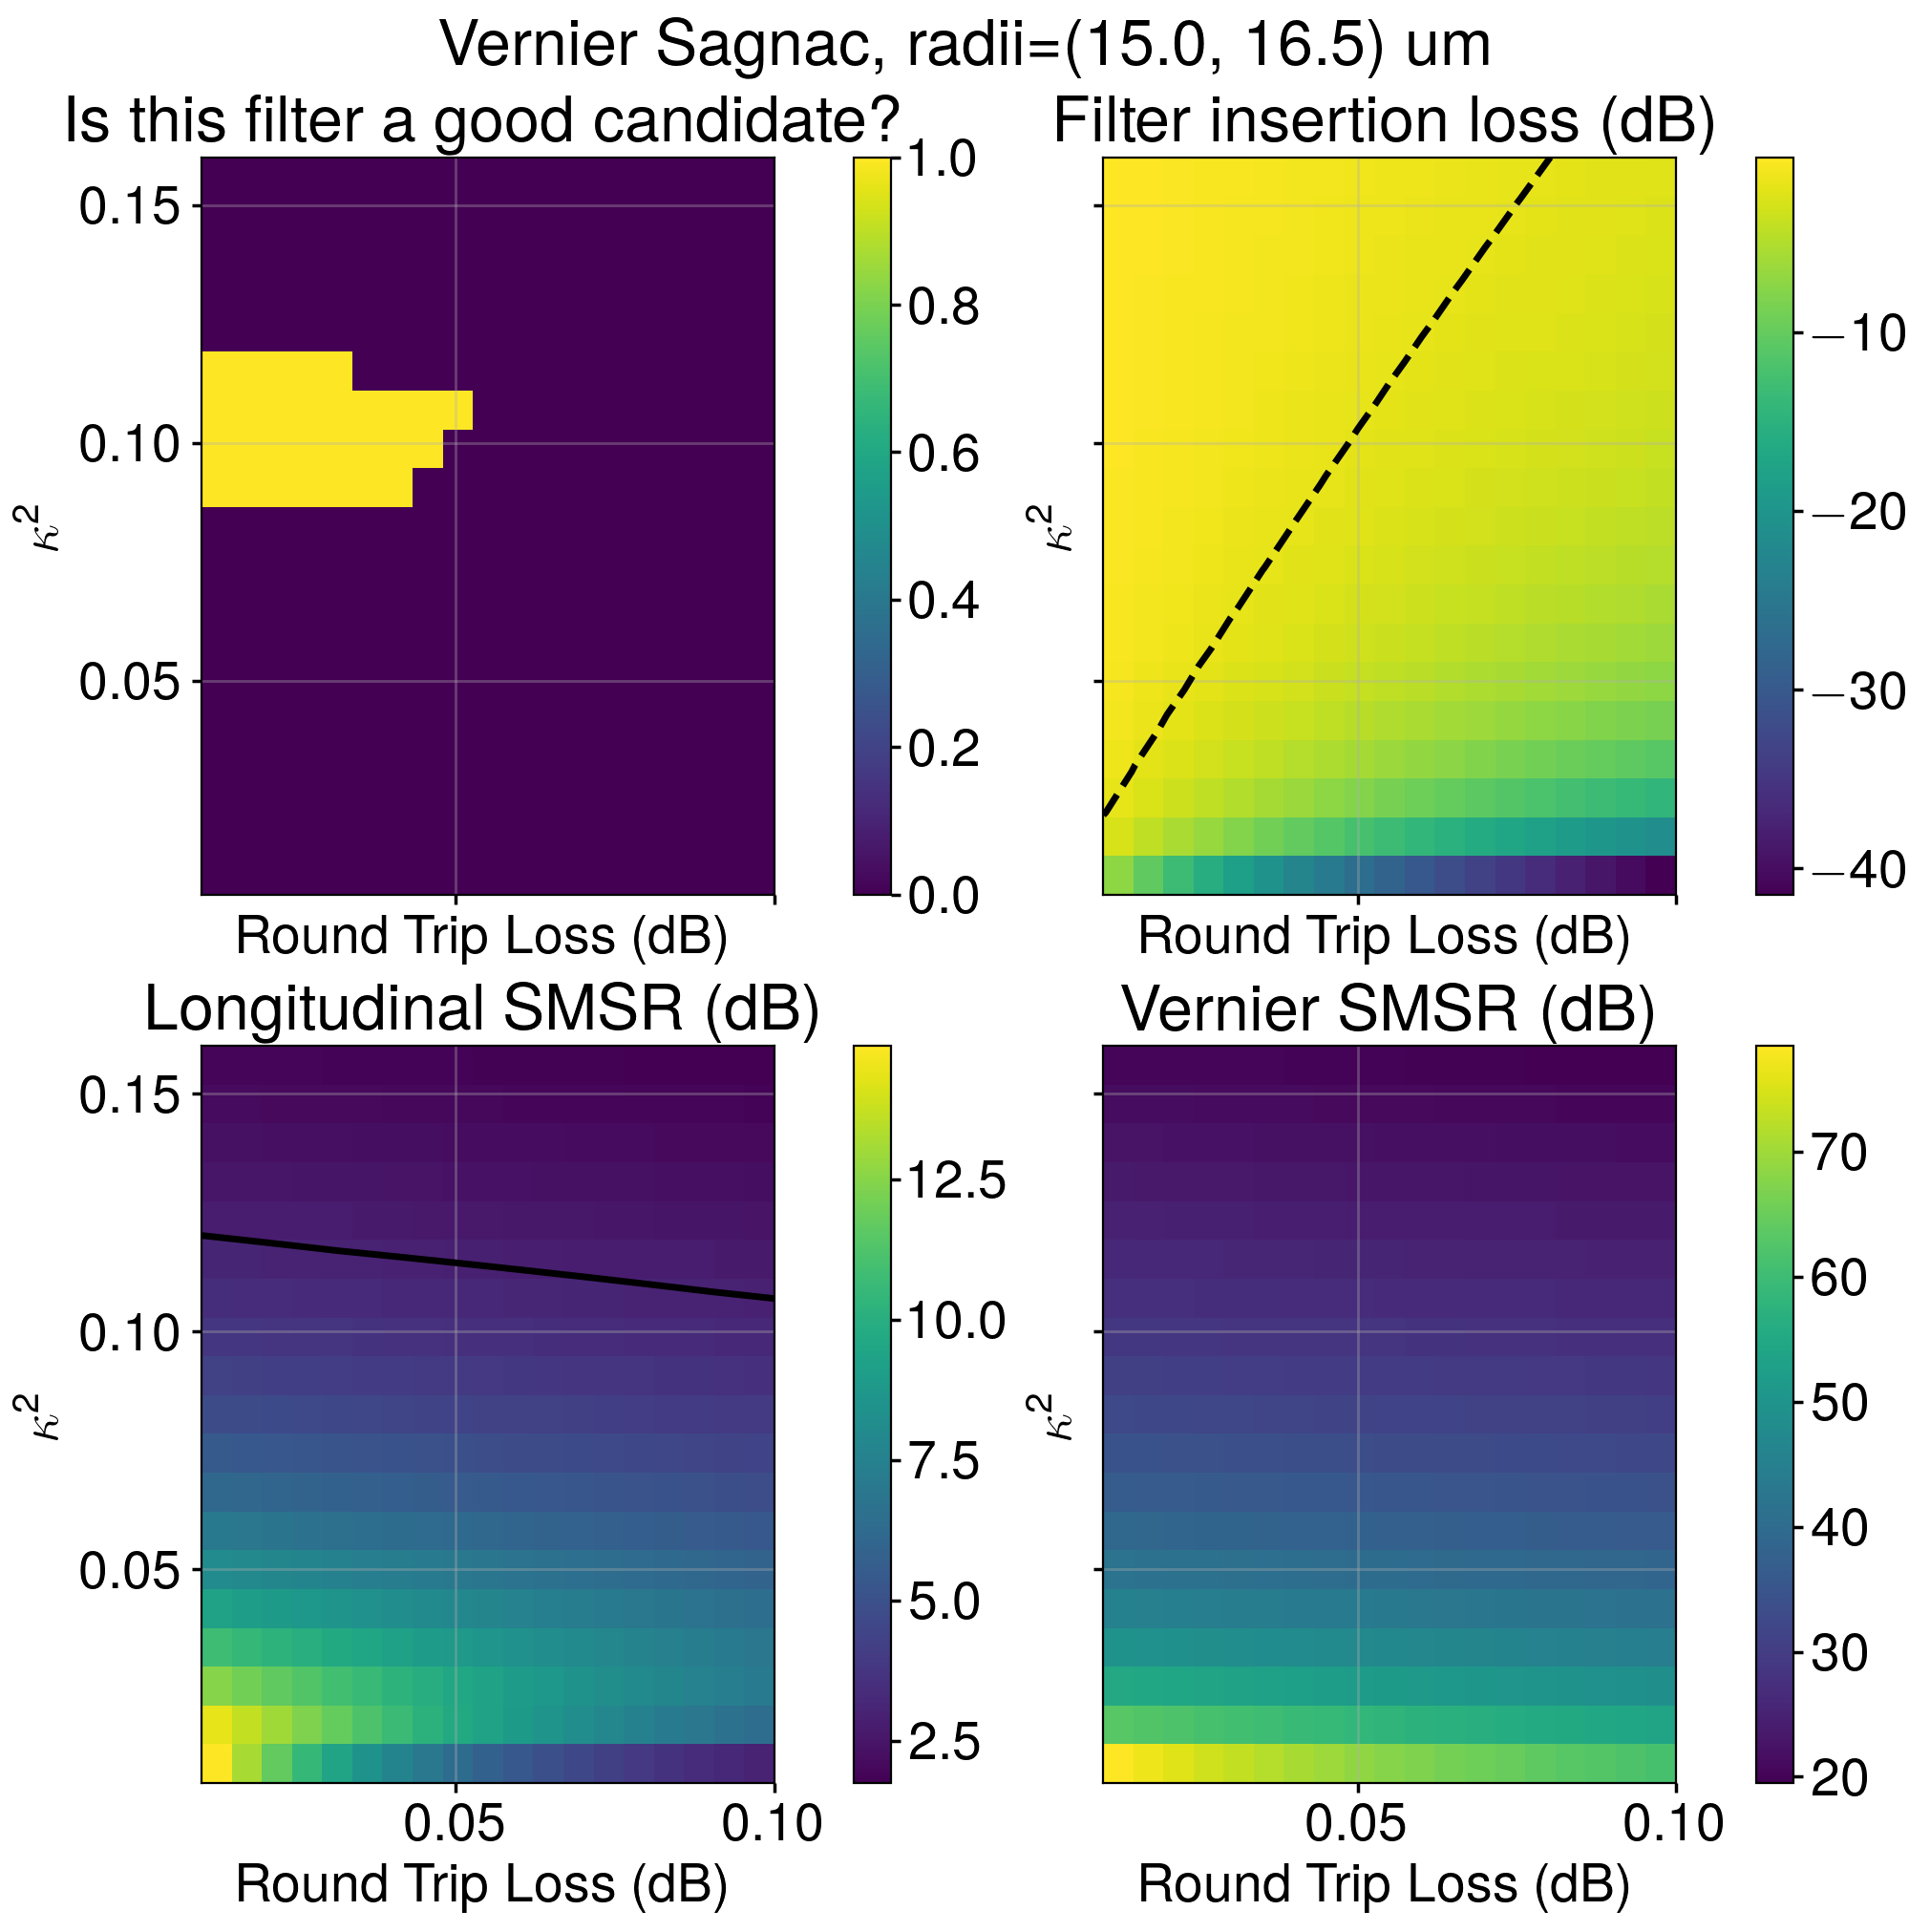

kappa^{2} sweep: 19it [04:21, 13.76s/it]


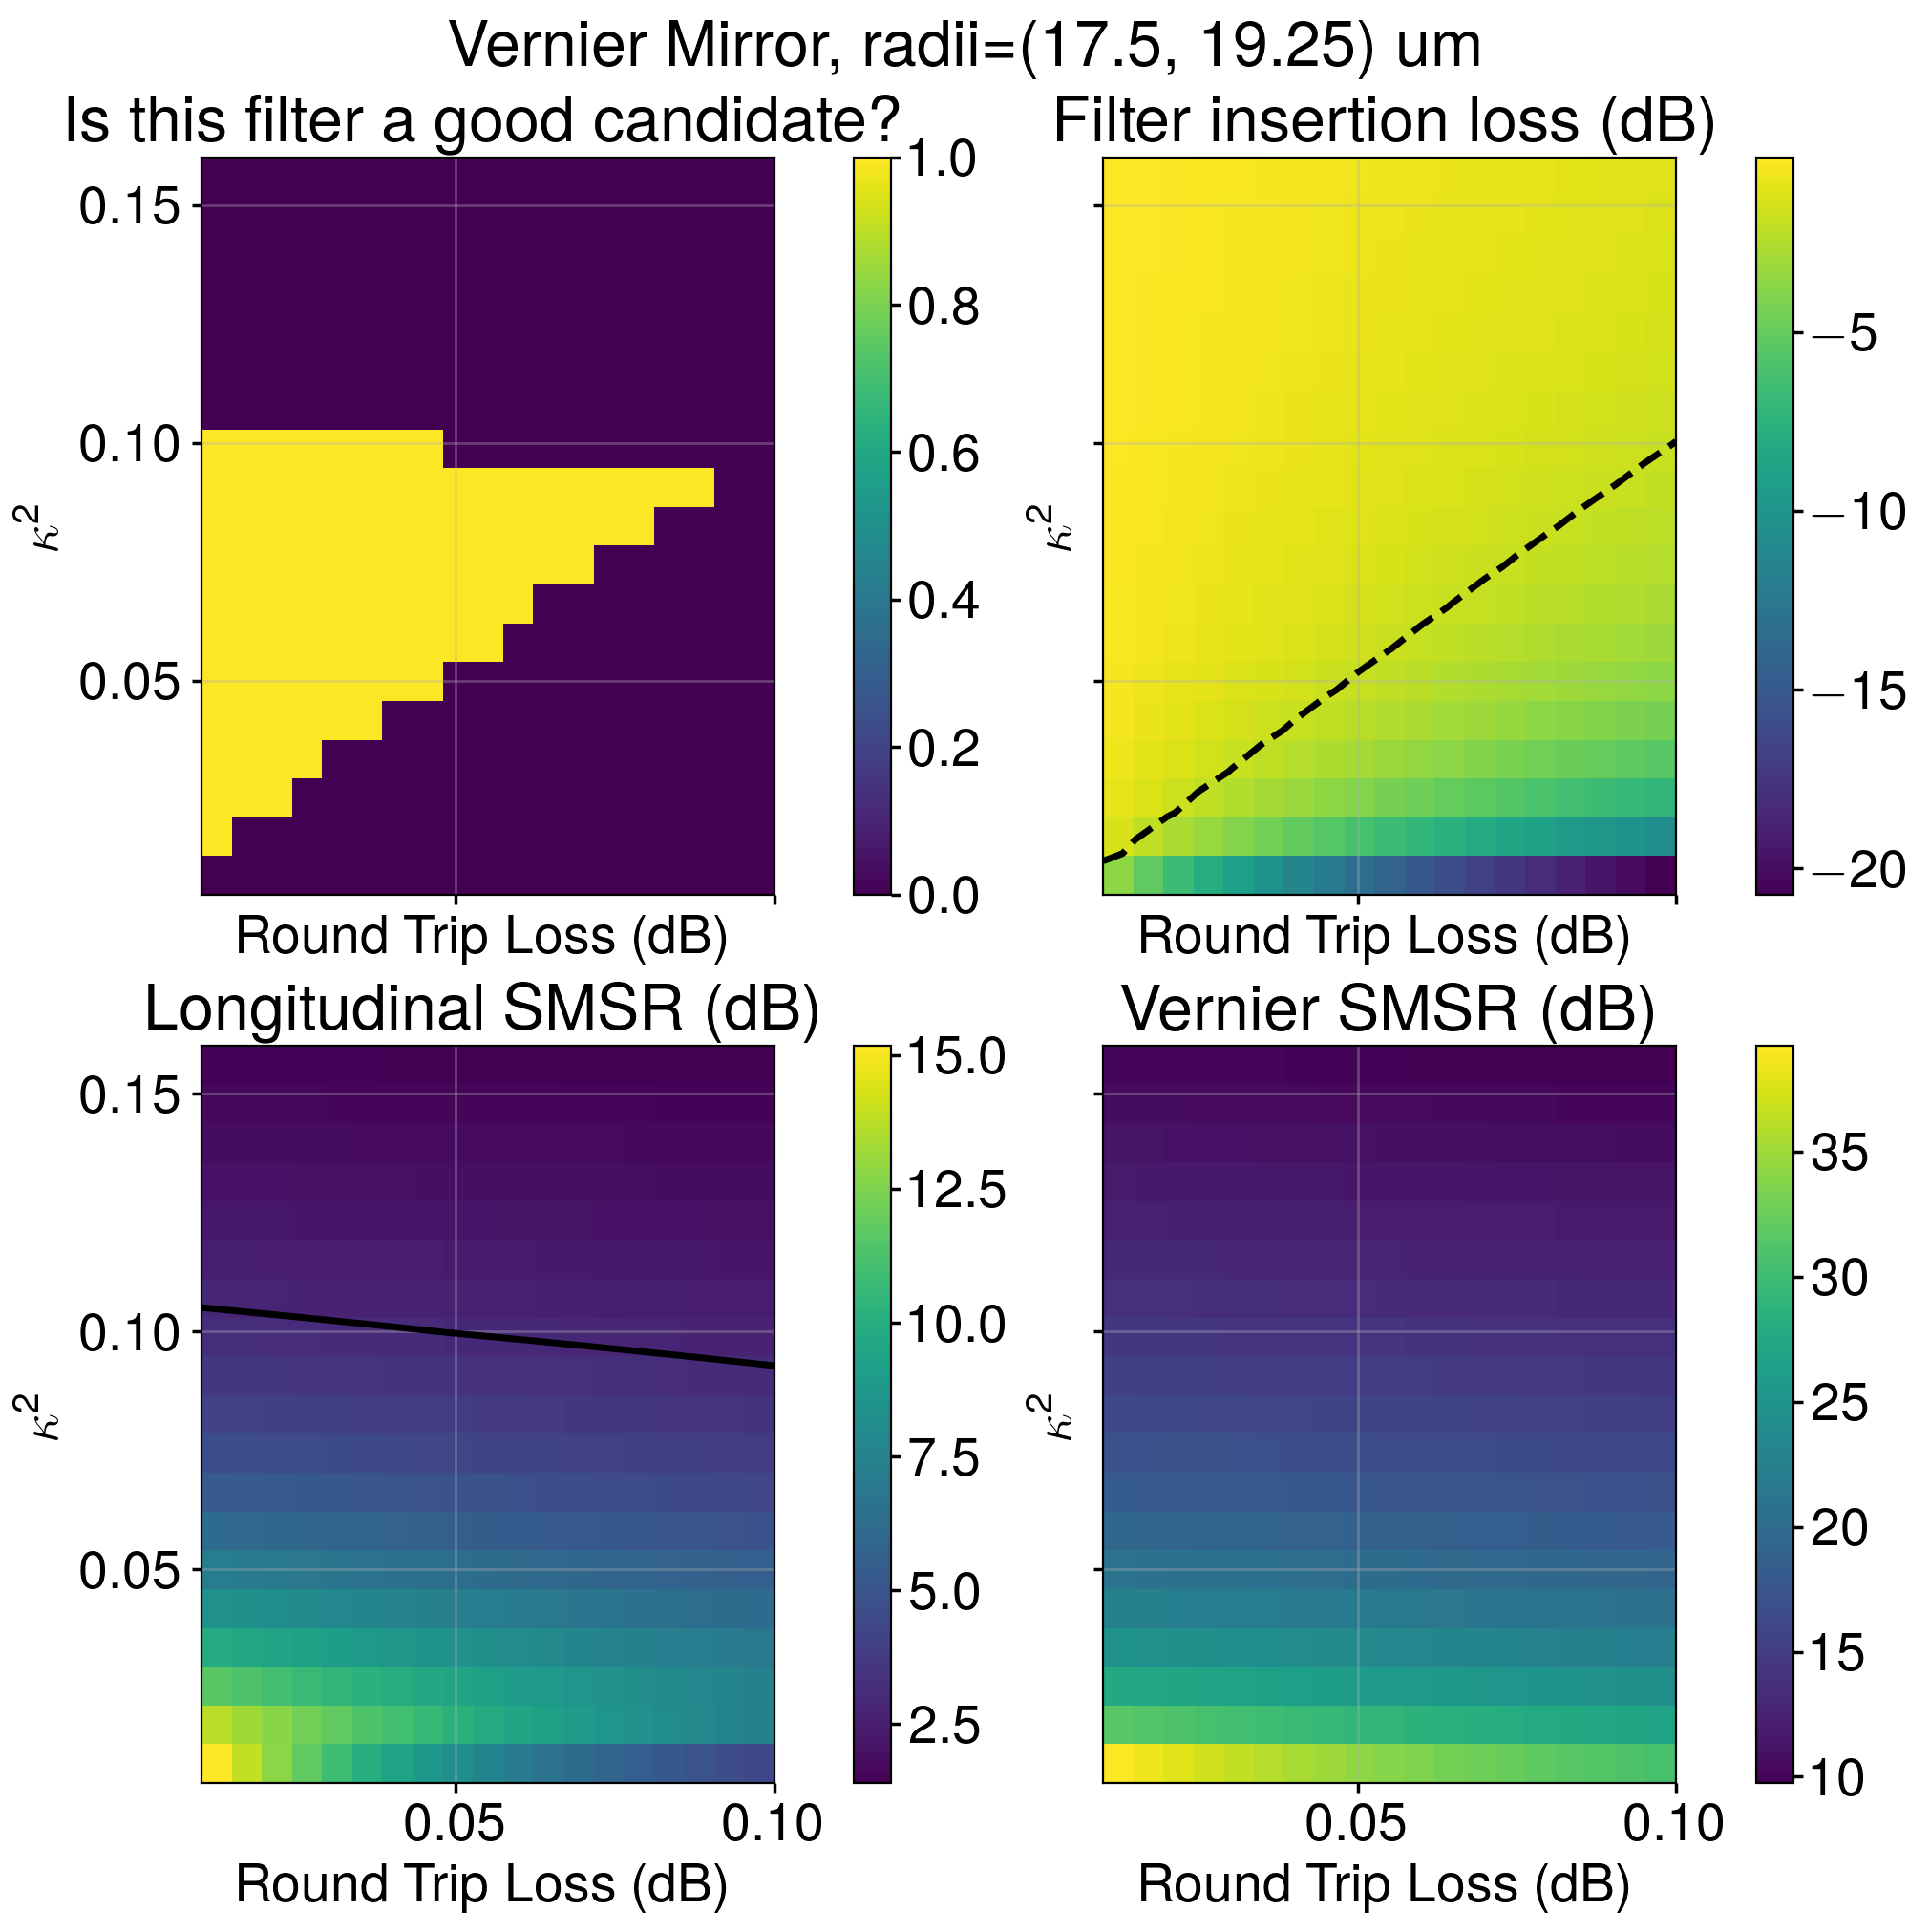

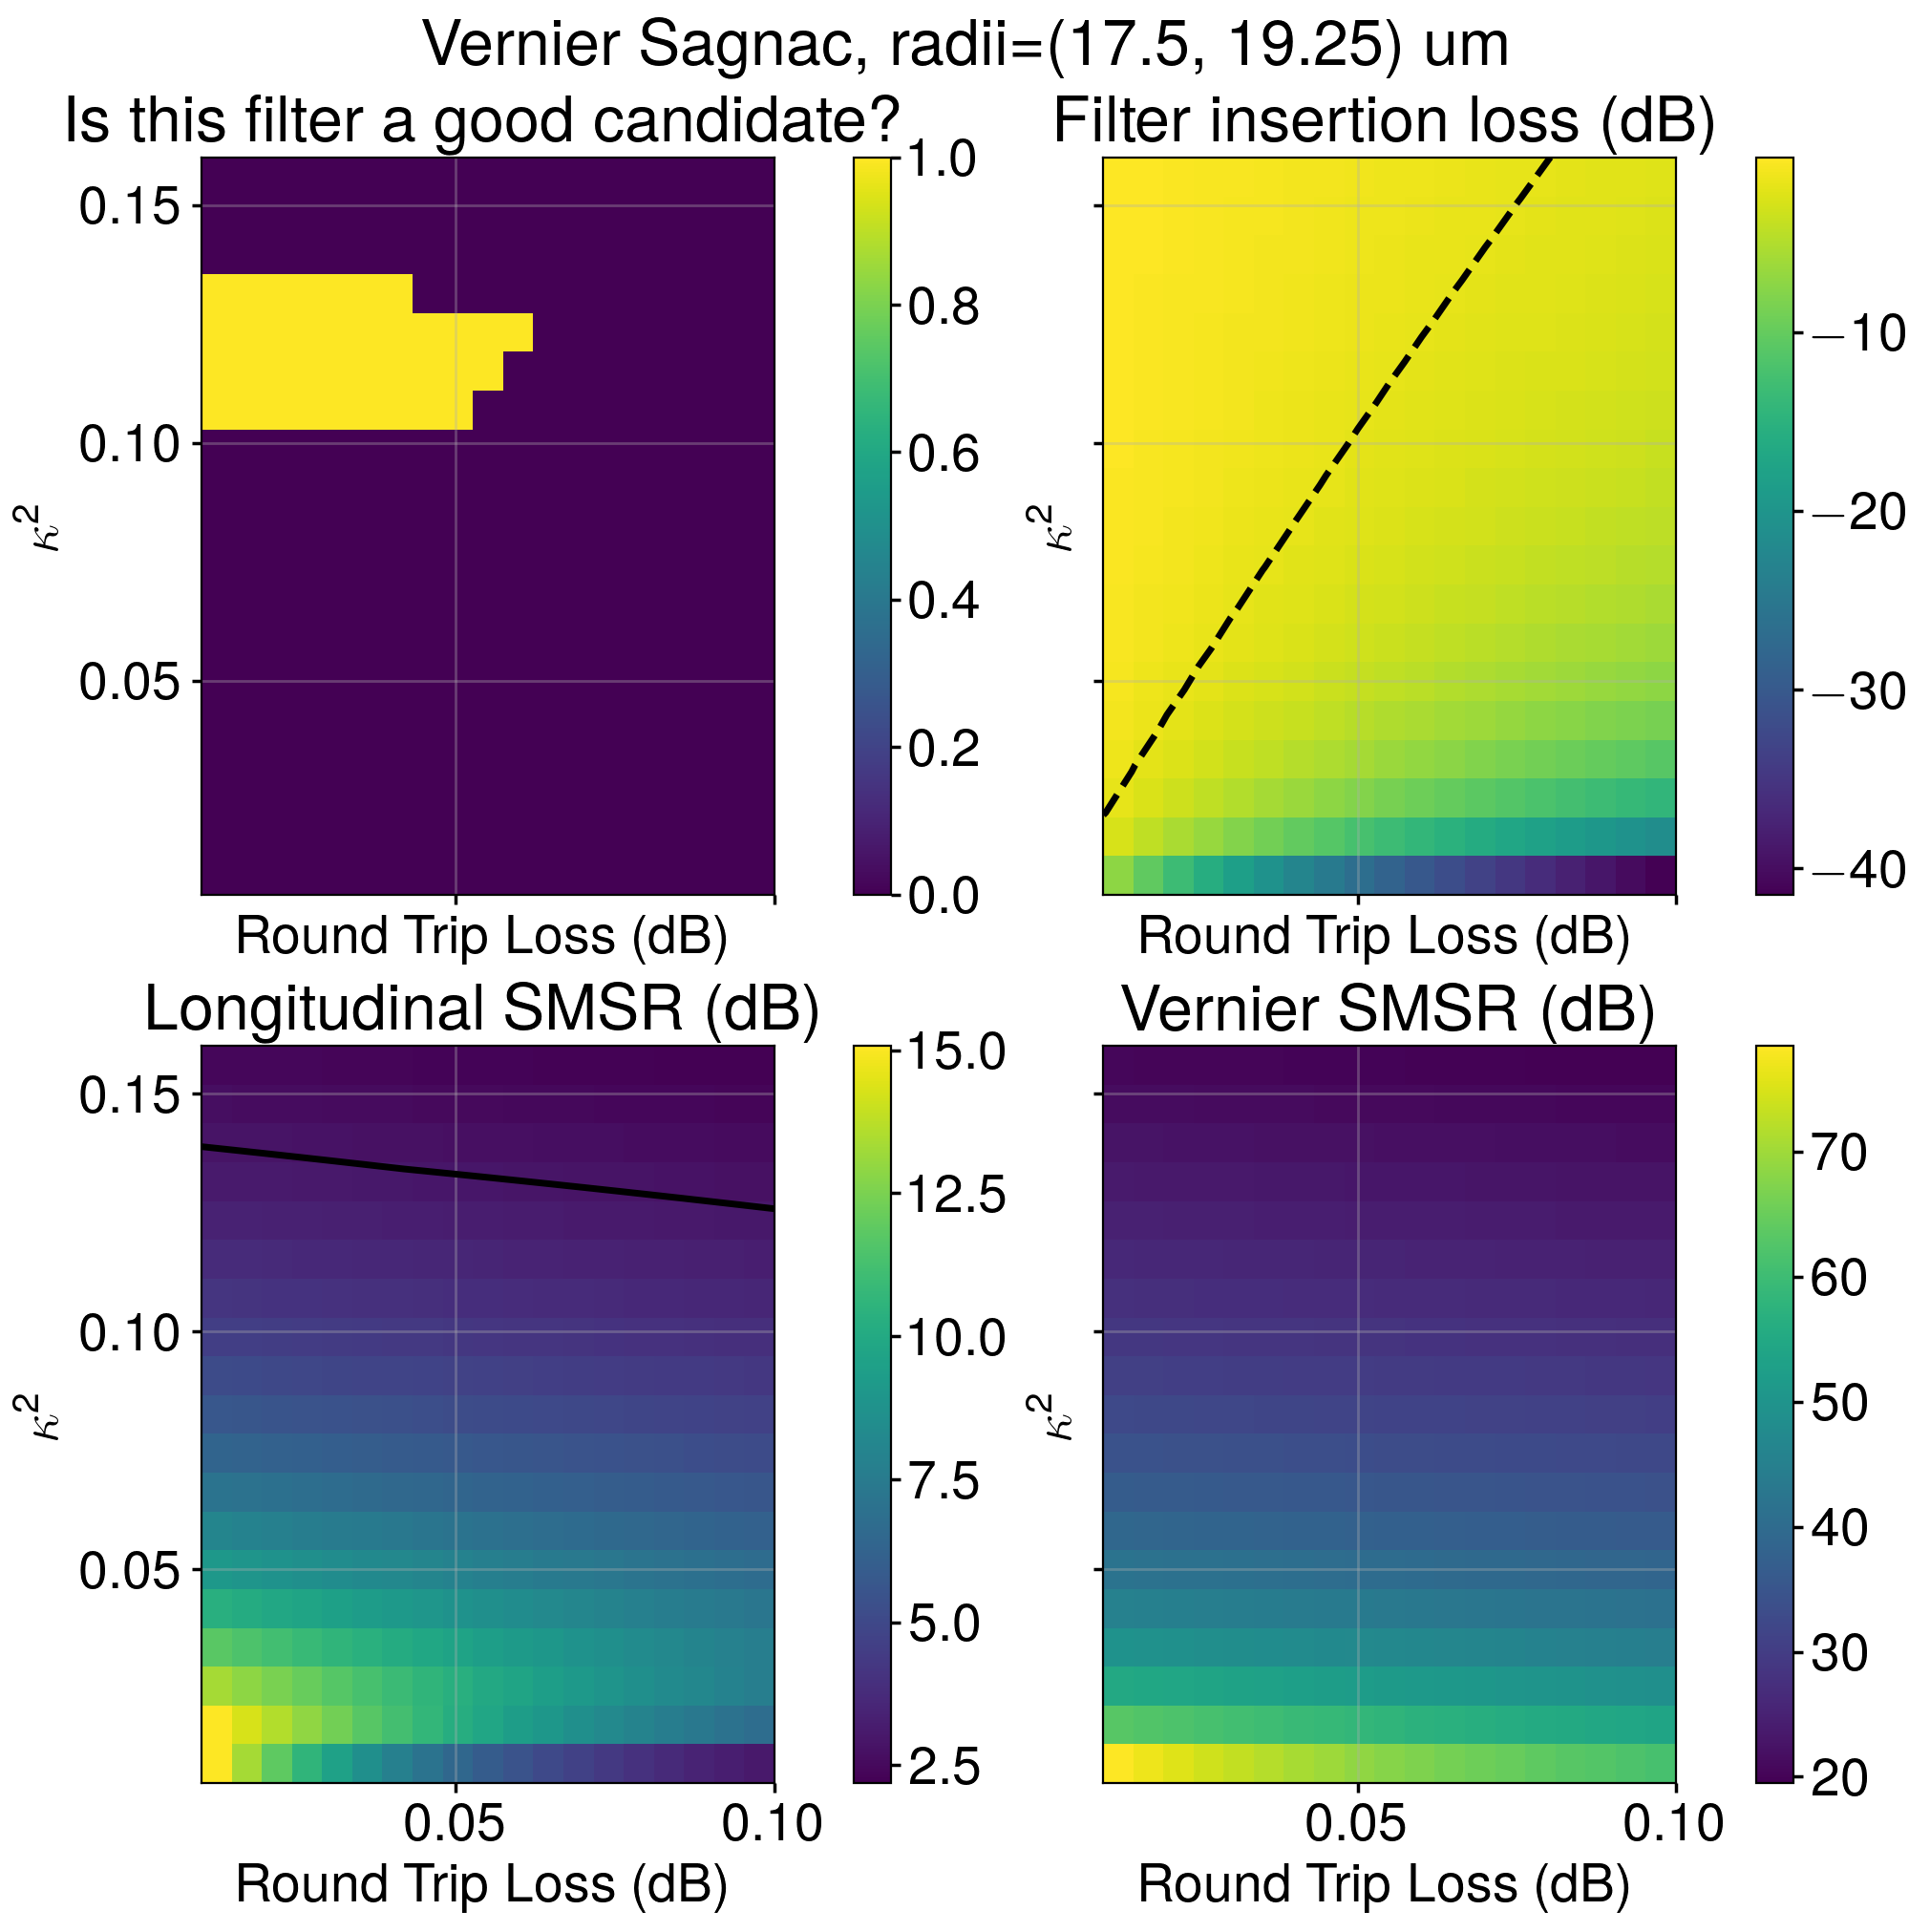

kappa^{2} sweep: 19it [04:22, 13.79s/it]


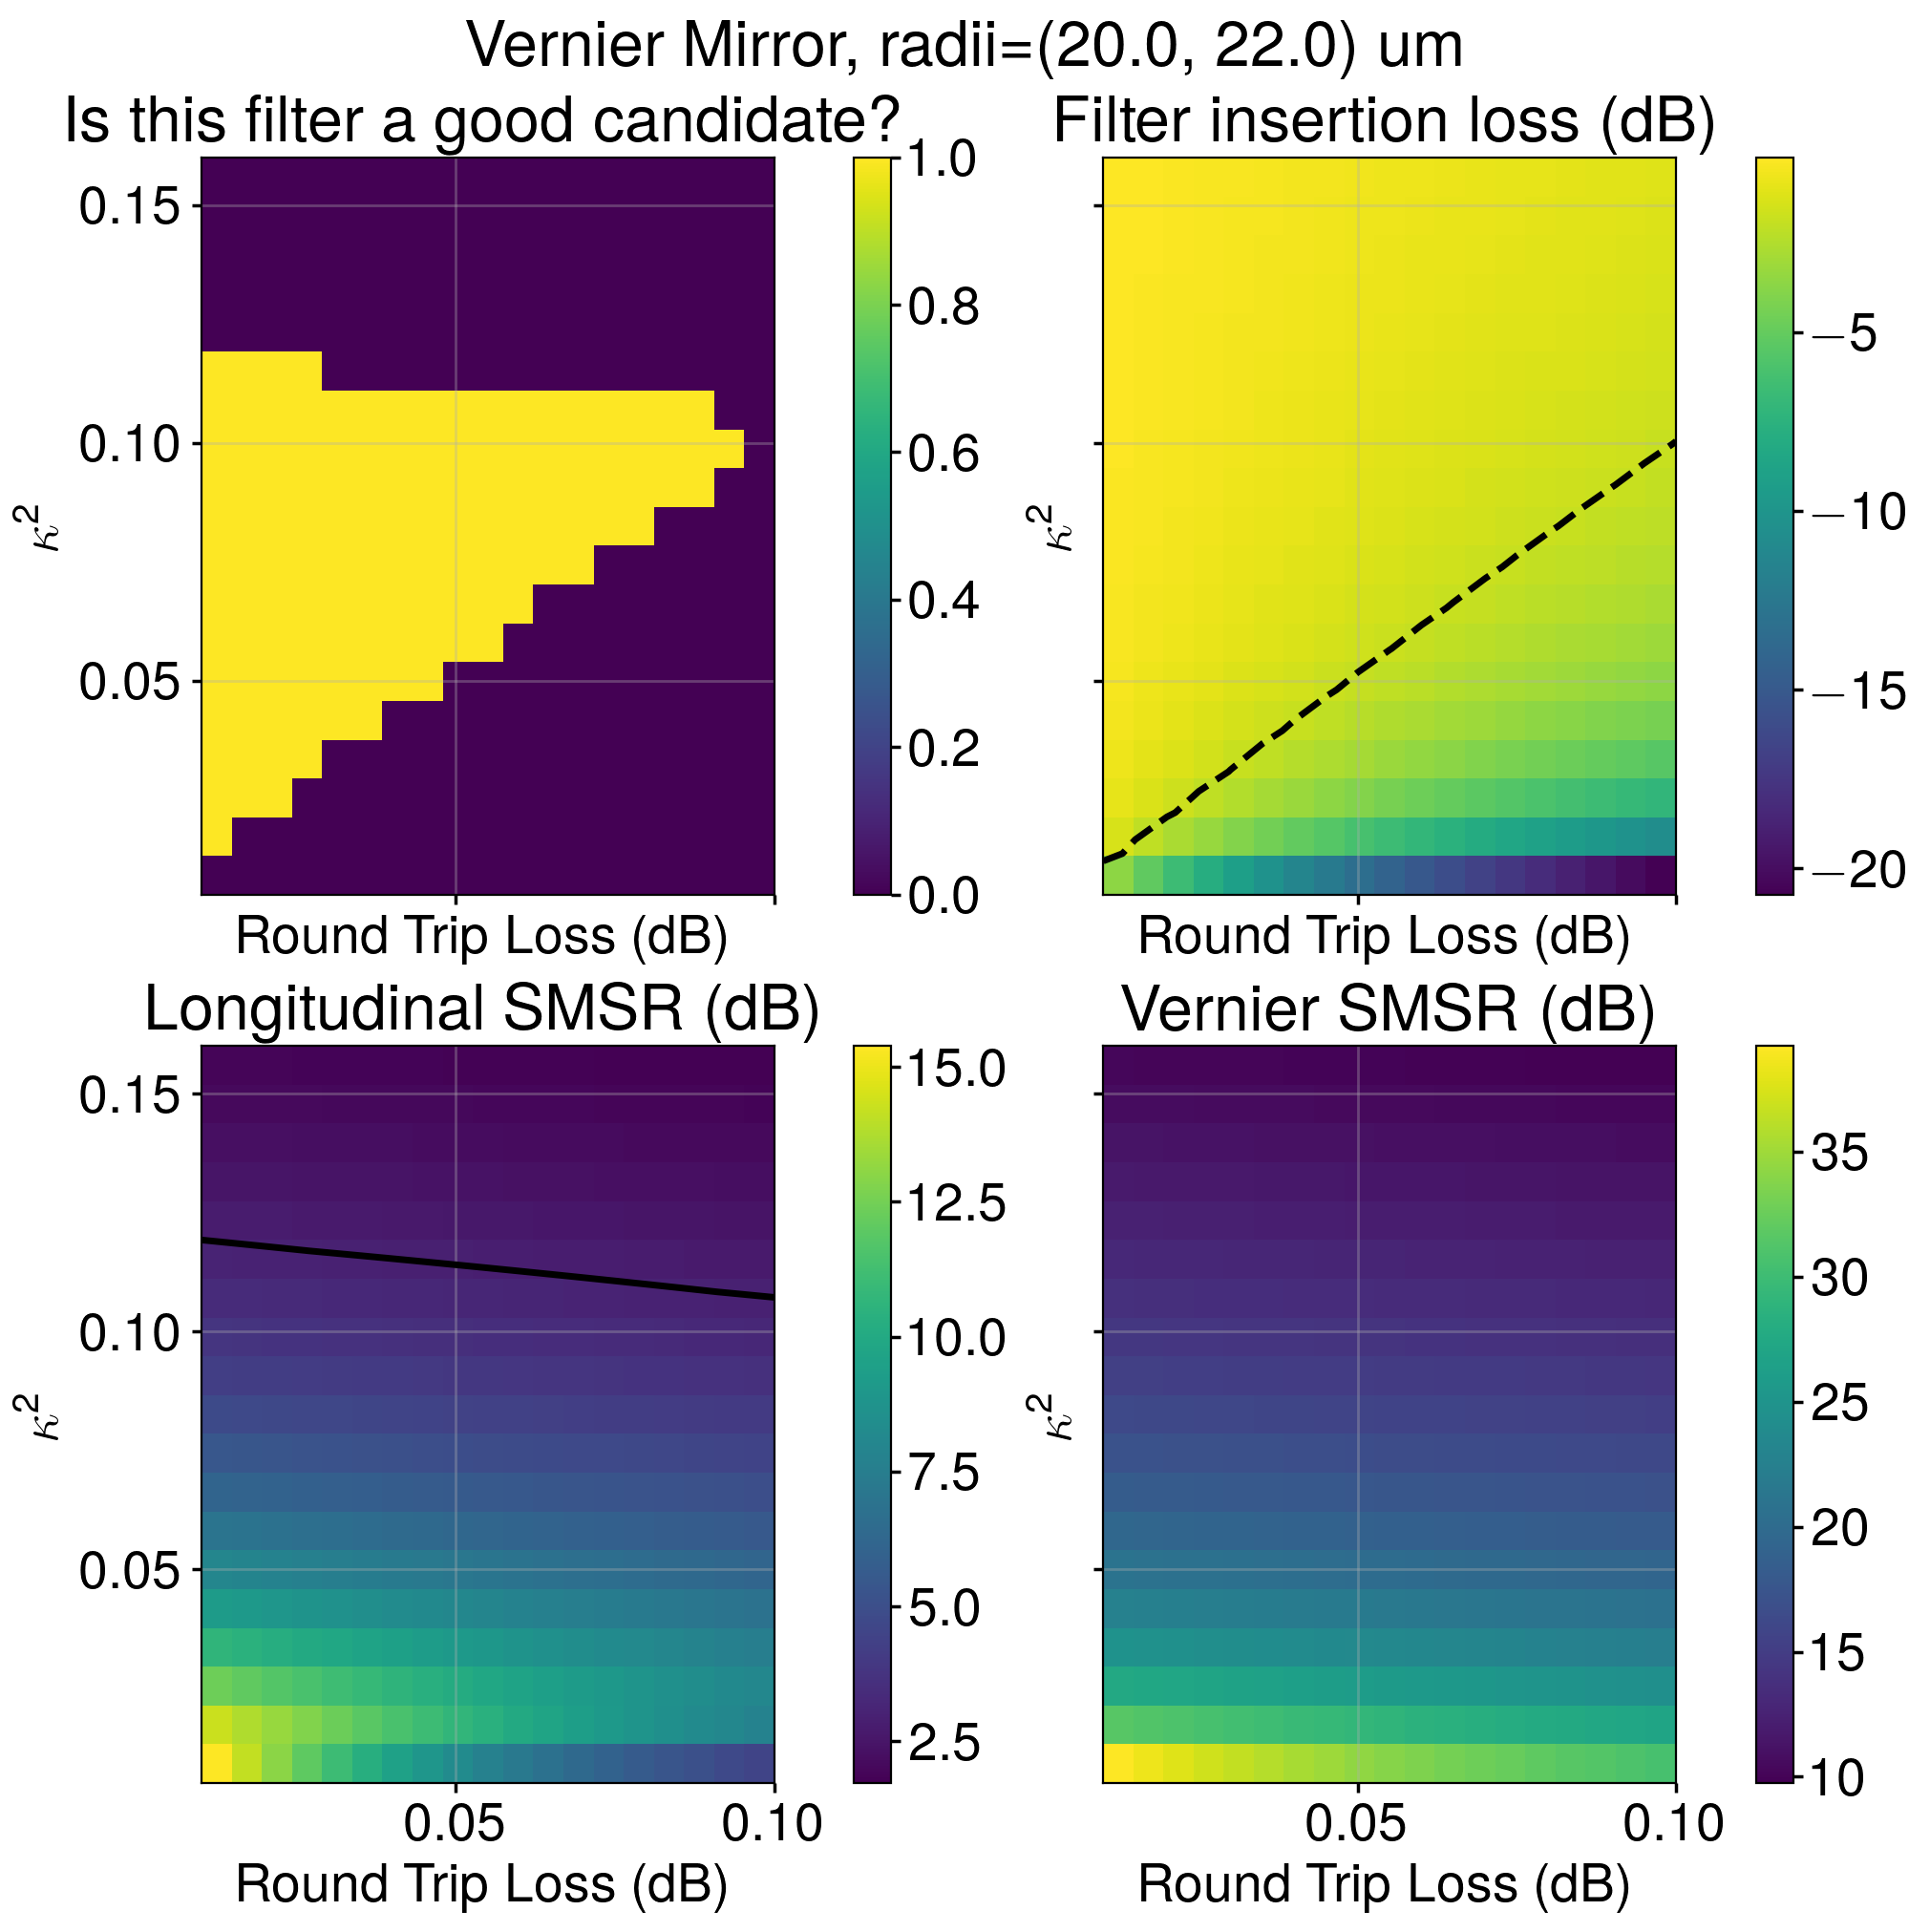

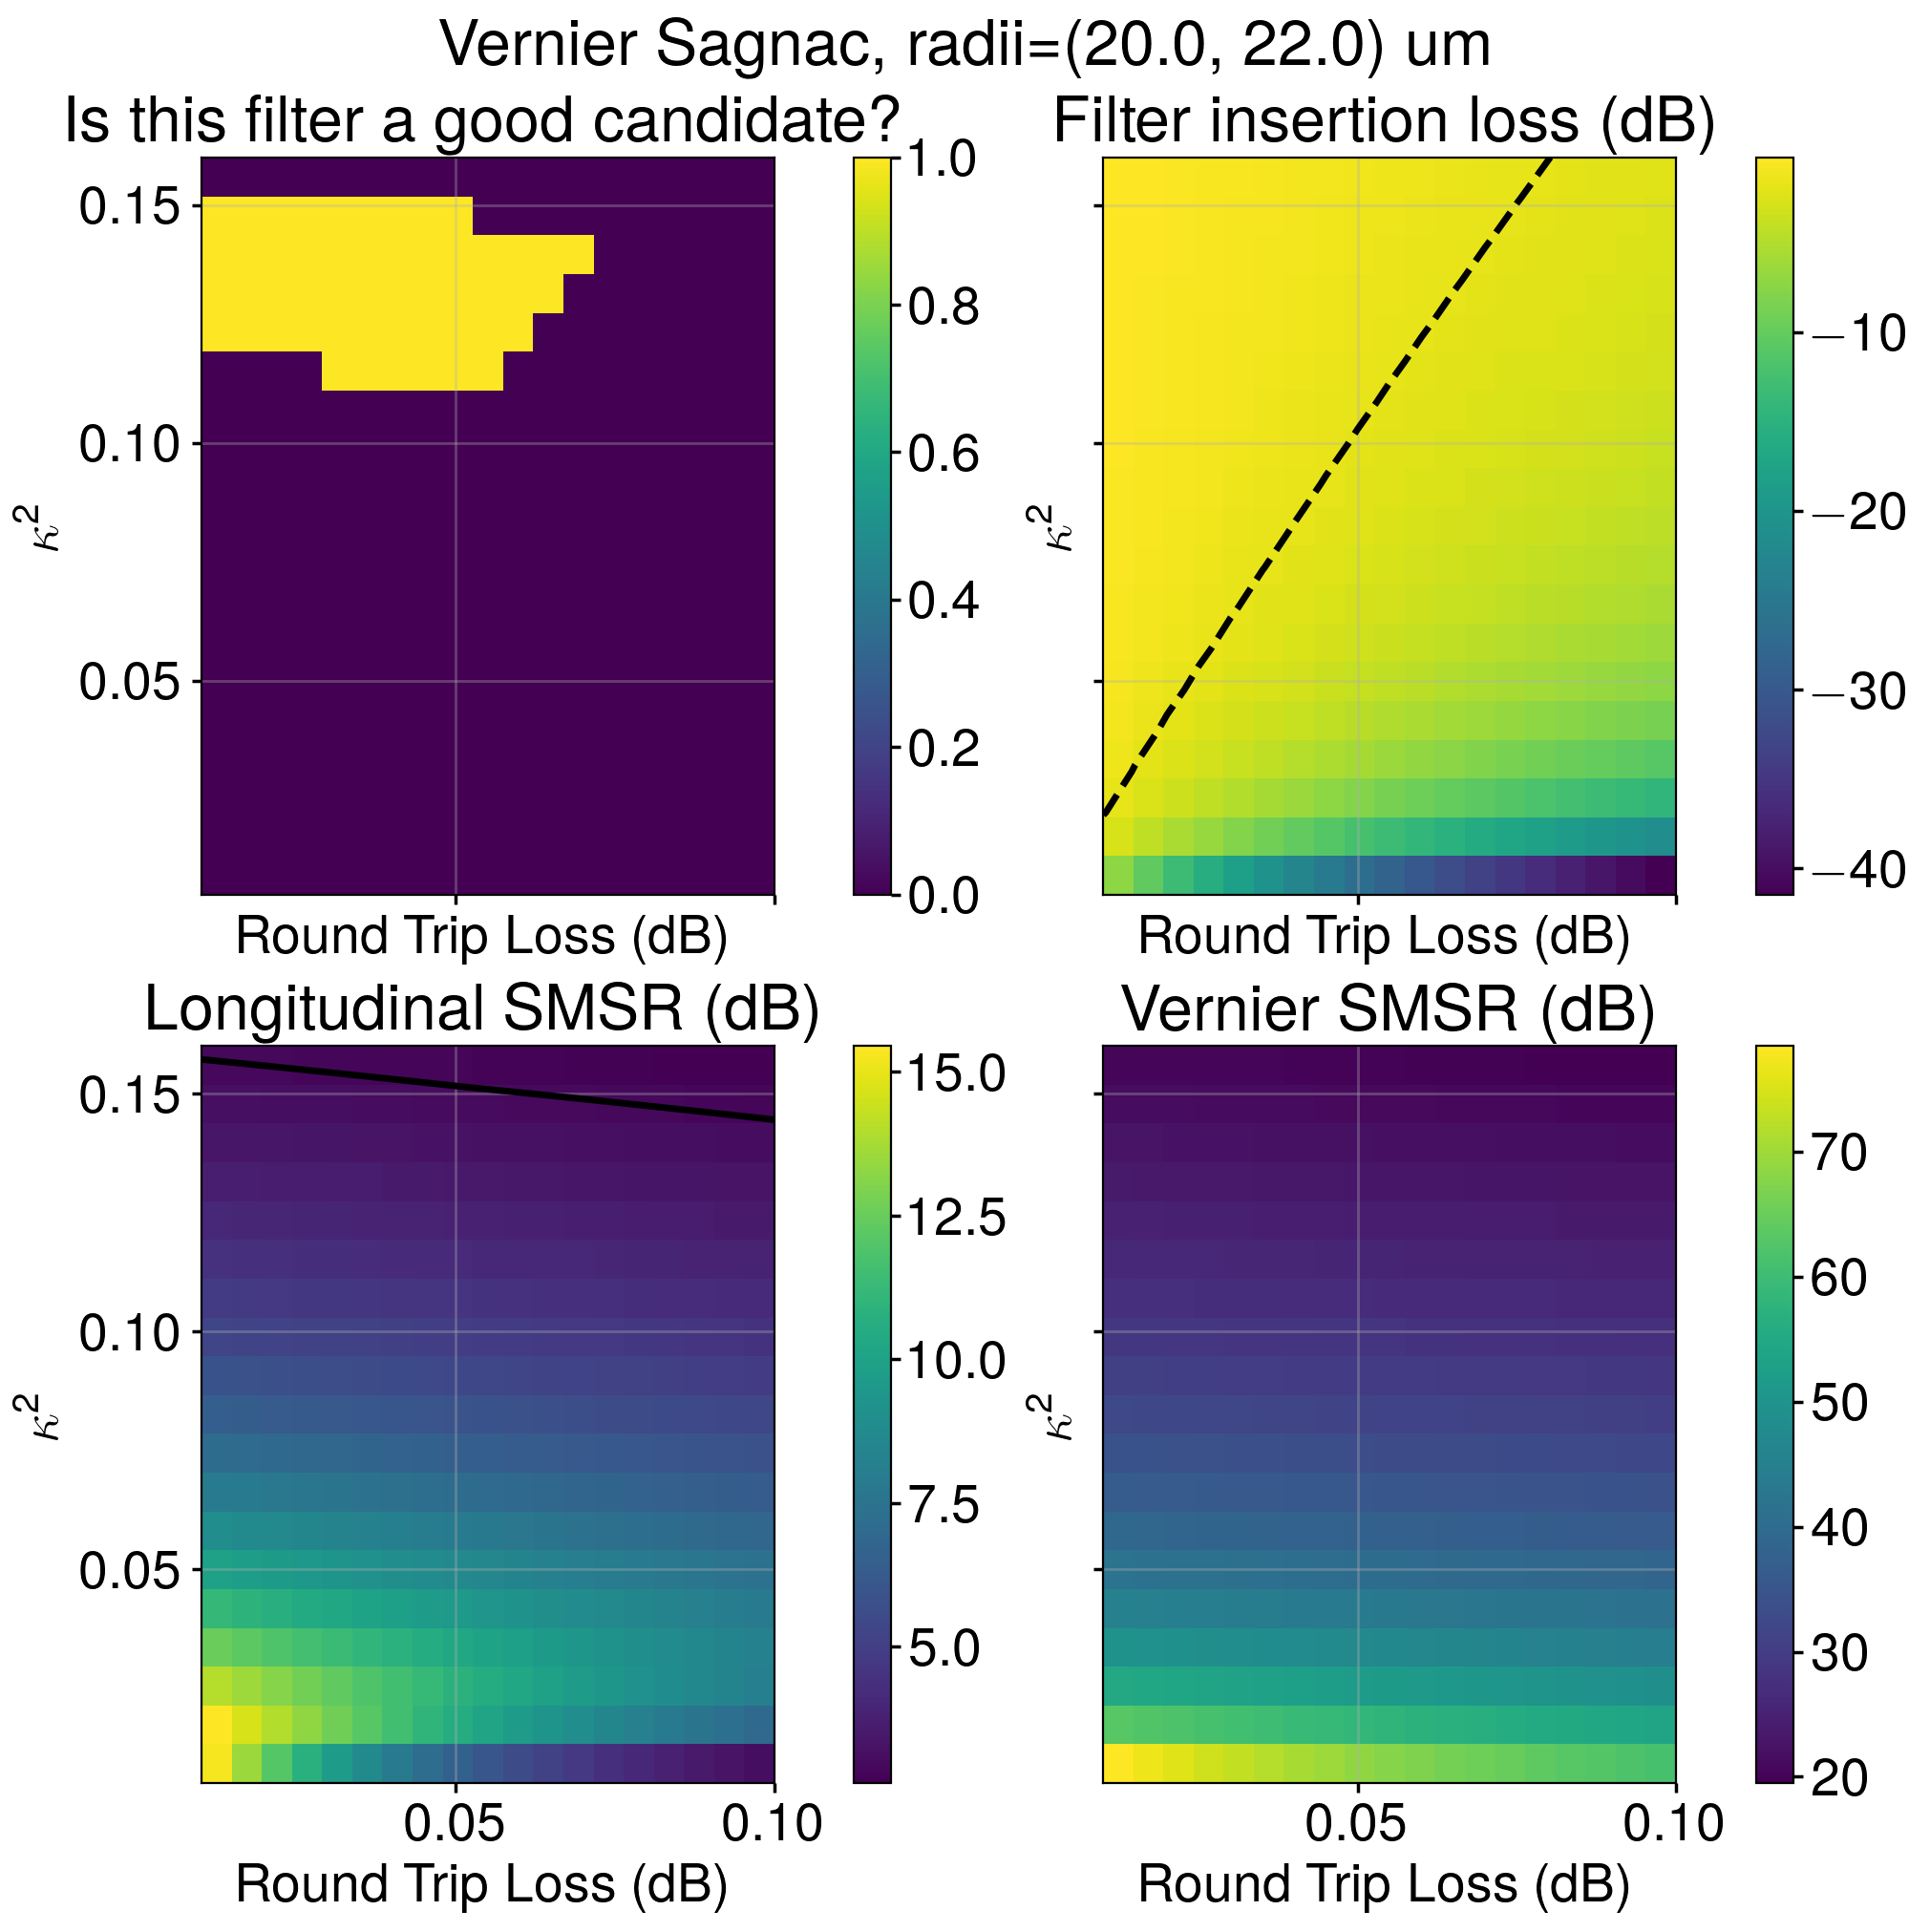

Vernier mirror device is a good candidate
Vernier sagnac device does not have sufficient longitudinal SMSR
Sagnac device is not a good candidate


False

In [146]:
def plot_design_tradeoff_space(r1,r2):
    kappa_squared_sweep = np.linspace(0.005,0.16,num=19)
    round_trip_loss_db_sweep = np.linspace(0.01,0.1,num=19)

    mirror_good_candidate_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    mirror_insertion_loss_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    mirror_long_SMSR_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    mirror_vernier_SMSR_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))

    sagnac_good_candidate_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    sagnac_insertion_loss_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    sagnac_long_SMSR_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))
    sagnac_vernier_SMSR_storage = np.zeros((kappa_squared_sweep.size,round_trip_loss_db_sweep.size))

    for i,k2 in tqdm(enumerate(kappa_squared_sweep),desc=r'kappa^{2} sweep'):
        for j,rtl_dB in enumerate(round_trip_loss_db_sweep):
            tmp = Vernier_rings_in_longitudinal_cavity(4e-3,k2,r1,r2,round_trip_loss_dB=rtl_dB)
            mirror_insertion_loss_storage[i,j] = 10*np.log10(tmp.transmission_through_mirror())
            mirror_long_SMSR_storage[i,j] = 10*np.log10(tmp.Mirror_longitudinal_SMSR())
            mirror_vernier_SMSR_storage[i,j] = 10*np.log10(tmp.Mirror_Vernier_SMSR())

            sagnac_insertion_loss_storage[i,j] = 10*np.log10(tmp.transmission_through_sagnac())
            sagnac_long_SMSR_storage[i,j] = 10*np.log10(tmp.Sagnac_longitudinal_SMSR())
            sagnac_vernier_SMSR_storage[i,j] = 10*np.log10(tmp.Sagnac_Vernier_SMSR())
            if tmp.is_device_a_good_candidate(mirror=True,printy=False) == True:
                mirror_good_candidate_storage[i,j] = 1
            elif tmp.is_device_a_good_candidate(mirror=False,printy=False) == True:
                sagnac_good_candidate_storage[i,j] = 1
    
    fig,axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True, figsize=(10,10))
    p1ref = axs[0,0].imshow(mirror_good_candidate_storage,extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p2ref = axs[0,1].imshow(mirror_insertion_loss_storage,extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p3ref = axs[1,0].imshow(mirror_long_SMSR_storage,extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p4ref = axs[1,1].imshow(mirror_vernier_SMSR_storage,extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')

    plt.colorbar(p1ref,ax=axs[0,0])
    plt.colorbar(p2ref,ax=axs[0,1])
    plt.colorbar(p3ref,ax=axs[1,0])
    plt.colorbar(p4ref,ax=axs[1,1])

    axs[0,1].contour(round_trip_loss_db_sweep, kappa_squared_sweep, mirror_insertion_loss_storage, [-1.8], colors='k')
    axs[1,0].contour(round_trip_loss_db_sweep, kappa_squared_sweep, mirror_long_SMSR_storage, [3], colors='k')
    axs[1,1].contour(round_trip_loss_db_sweep, kappa_squared_sweep, mirror_vernier_SMSR_storage, [3], colors='k')

    axs[0,0].set_title("Is this filter a good candidate?")
    axs[0,1].set_title("Filter insertion loss (dB)")
    axs[1,0].set_title("Longitudinal SMSR (dB)")
    axs[1,1].set_title("Vernier SMSR (dB)")
    axs[0,0].set_xlabel("Round Trip Loss (dB)")
    axs[0,1].set_xlabel("Round Trip Loss (dB)")
    axs[1,0].set_xlabel("Round Trip Loss (dB)")
    axs[1,1].set_xlabel("Round Trip Loss (dB)")
    axs[0,0].set_ylabel(r"$\kappa^{2}$")
    axs[0,1].set_ylabel(r"$\kappa^{2}$")
    axs[1,0].set_ylabel(r"$\kappa^{2}$")
    axs[1,1].set_ylabel(r"$\kappa^{2}$")
    plt.suptitle(f"Vernier Mirror, radii={round(r1*1e6,2),round(r2*1e6,2)} um")
    plt.show()

    fig,axs = plt.subplots(ncols=2,nrows=2,sharex=True,sharey=True,  figsize=(10,10))
    p1ref = axs[0,0].imshow(sagnac_good_candidate_storage, extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p2ref = axs[0,1].imshow(sagnac_insertion_loss_storage, extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p3ref = axs[1,0].imshow(sagnac_long_SMSR_storage, extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')
    p4ref = axs[1,1].imshow(sagnac_vernier_SMSR_storage, extent=[np.min(round_trip_loss_db_sweep),np.max(round_trip_loss_db_sweep),np.min(kappa_squared_sweep),np.max(kappa_squared_sweep)],origin='lower',aspect='auto')

    plt.colorbar(p1ref,ax=axs[0,0])
    plt.colorbar(p2ref,ax=axs[0,1])
    plt.colorbar(p3ref,ax=axs[1,0])
    plt.colorbar(p4ref,ax=axs[1,1])

    axs[0,1].contour(round_trip_loss_db_sweep, kappa_squared_sweep, sagnac_insertion_loss_storage, [-1.8], colors='k')
    axs[1,0].contour(round_trip_loss_db_sweep, kappa_squared_sweep, sagnac_long_SMSR_storage, [3], colors='k')
    axs[1,1].contour(round_trip_loss_db_sweep, kappa_squared_sweep, sagnac_vernier_SMSR_storage, [3], colors='k')

    axs[0,0].set_title("Is this filter a good candidate?")
    axs[0,1].set_title("Filter insertion loss (dB)")
    axs[1,0].set_title("Longitudinal SMSR (dB)")
    axs[1,1].set_title("Vernier SMSR (dB)")
    axs[0,0].set_xlabel("Round Trip Loss (dB)")
    axs[0,1].set_xlabel("Round Trip Loss (dB)")
    axs[1,0].set_xlabel("Round Trip Loss (dB)")
    axs[1,1].set_xlabel("Round Trip Loss (dB)")
    axs[0,0].set_ylabel(r"$\kappa^{2}$")
    axs[0,1].set_ylabel(r"$\kappa^{2}$")
    axs[1,0].set_ylabel(r"$\kappa^{2}$")
    axs[1,1].set_ylabel(r"$\kappa^{2}$")
    plt.suptitle(f"Vernier Sagnac, radii={round(r1*1e6,2),round(r2*1e6,2)} um")
    plt.show()

# radius_sweep = np.linspace(10e-6,20e-6,num=5)
radius_pair_sweep = [(12e-6,1.2*12e-6),(15e-6,1.1*15e-6),(17.5e-6,1.1*17.5e-6),(20e-6,1.1*20e-6)]
for r1,r2 in radius_pair_sweep:
    plot_design_tradeoff_space(r1=r1,r2=r2)

r1 = 12e-6
r2 = 1.2*r1
tmp = Vernier_rings_in_longitudinal_cavity(4e-3,0.05,r1,r2,round_trip_loss_dB=0.04)
tmp.is_device_a_good_candidate(mirror=True,printy=True)
# plt.figure()
# wav,amp = tmp.Mirror_longitudinal_wavelength_sweep()
# plt.semilogy(wav,amp)
# plt.show()

r1 = 12e-6
r2 = 1.1*r1
tmp = Vernier_rings_in_longitudinal_cavity(4e-3,0.15,r1,r2,round_trip_loss_dB=0.04)
tmp.is_device_a_good_candidate(mirror=False,printy=True)